# 1. Постановка задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Требуется построить модель, которая предскажет температуру стали.

## 1.1 Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## 1.2 Блок-схема обработки

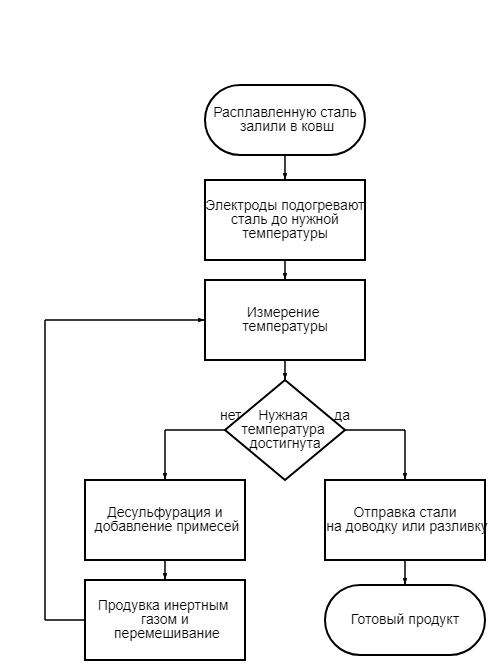

## 1.3 Иллюстрация установки

[Источник](https://metallurgist.pro/obrabotka-stali-v-ustanovke-kovsh-pech/)


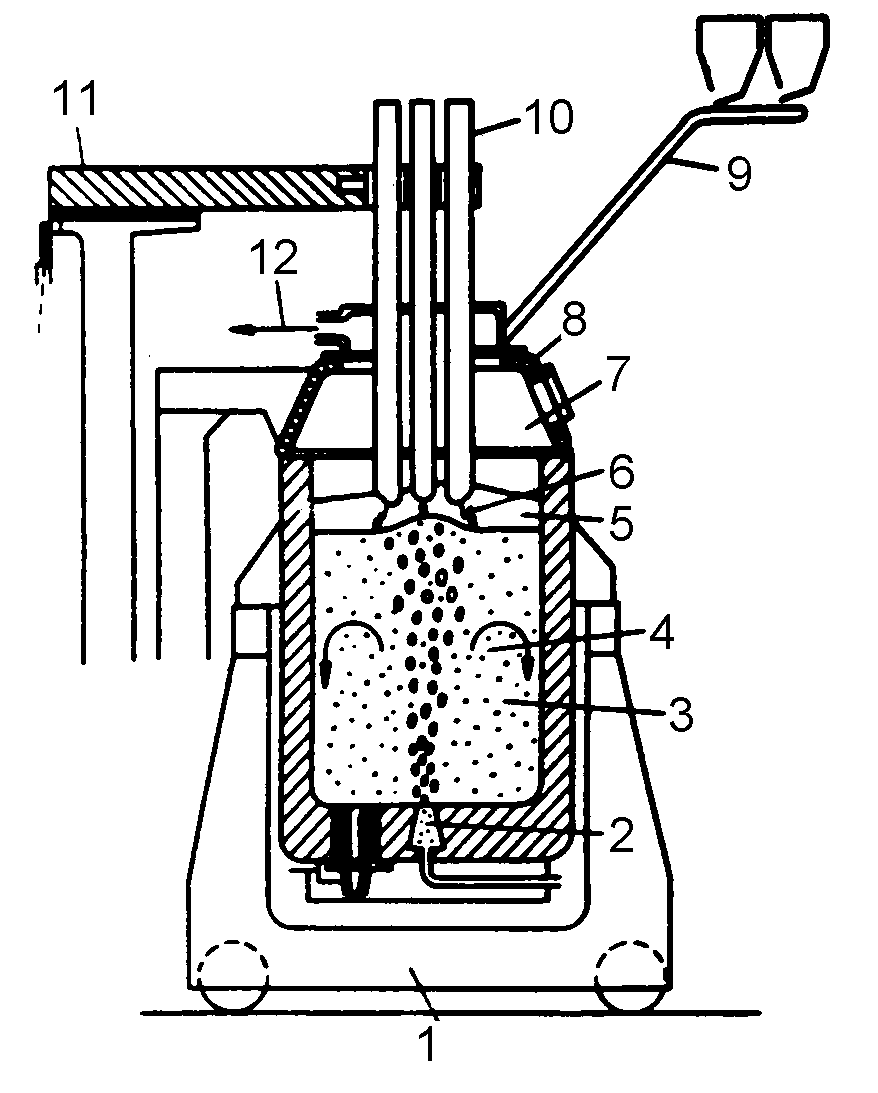

Схема установки ковш-печь для шлаковой обработки металла:
- 1 – сталевоз;
- 2 – пористая пробка для подачи аргона;
- 3 – металлический расплав;
- 4 – пузырьки инертного газа;
- 5 – основной шлак;
- 6 – погруженная в шлак электрическая дуга;
- 7 – инертная атмосфера;
- 8 – водоохлаждаемый свод;
- 9 – устройство для присадки ферросплавов;
- 10 – электроды;
- 11 – электропроводящие электрододержатели;
- 12 – отвод газа.

# 2. Исследовательский анализ исходных данных

## 2.1 Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## 2.2 Импорт библиотек и зависимостей

In [ ]:
# Libraries installing.
!pip install catboost
!pip install LightGBM
!pip install shap

# Libraries import.
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

# Plotly import .
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# ML dependencies.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from catboost import Pool
import lightgbm as lgbm
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

#from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

## 2.3 Импорт данных

In [ ]:
# Data import.
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/graduation_project/data_arc.csv')
    data_bulk = pd.read_csv('/content/drive/My Drive/Colab Notebooks/graduation_project/data_bulk.csv')
    data_bulk_time = pd.read_csv('/content/drive/My Drive/Colab Notebooks/graduation_project/data_bulk_time.csv')
    data_gas = pd.read_csv('/content/drive/My Drive/Colab Notebooks/graduation_project/data_gas.csv')
    data_temp = pd.read_csv('/content/drive/My Drive/Colab Notebooks/graduation_project/data_temp.csv')
    data_wire = pd.read_csv('/content/drive/My Drive/Colab Notebooks/graduation_project/data_wire.csv')
    data_wire_time = pd.read_csv('/content/drive/My Drive/Colab Notebooks/graduation_project/data_wire_time.csv')

## 2.4 Обзор данных

### 2.4.1 Содержимое

In [ ]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [ ]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [ ]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [ ]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.4.2 Типы и пропуски

In [ ]:
def nan_counts(data):
    '''This function calculate count & part of nans in inputed data.
        Input:
        data — the intrested data.

        Output:
        table with count & part of nans.'''

    nan_stat = pd.DataFrame(data.isna().sum())
    nan_stat['part_%'] = nan_stat[0] * 100 / data.shape[0]
    nan_stat.columns = ['nan_counts', 'part_%']
    return nan_stat[(nan_stat['part_%'] > 0)].sort_values('part_%', ascending = False)

In [ ]:
# Data types & gaps review.
for data, name in zip([data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time],
                      ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Таблица:', name)
    # Types.
    print('Типы данных:')
    print(data.info())
    print()
    # NaNs.
    print('Пропуски: \n', nan_counts(data))
    print()
    # Total numer of parties.
    print('Количество уникальных значений столбца "key":', len(data['key'].unique()))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Таблица: data_arc
Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Пропуски: 
 Empty DataFrame
Columns: [nan_counts, part_%]
Index: []

Количество уникальных значений столбца "key": 3214
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Таблица: data_bulk
Типы данных:
<class 'pandas.

### 2.4.3 Явные дубликаты

In [ ]:
for data, name in zip([data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time],
                      ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']):
    print('Таблица:', name)
    print('Явных дубликатов в выборке: {}'.format(data.duplicated().sum()))
    print()

Таблица: data_arc
Явных дубликатов в выборке: 0

Таблица: data_bulk
Явных дубликатов в выборке: 0

Таблица: data_bulk_time
Явных дубликатов в выборке: 0

Таблица: data_gas
Явных дубликатов в выборке: 0

Таблица: data_temp
Явных дубликатов в выборке: 0

Таблица: data_wire
Явных дубликатов в выборке: 0

Таблица: data_wire_time
Явных дубликатов в выборке: 0



### 2.4.4 Анализ числовых значений

In [ ]:
def float_data_analyzer(data, columns, bins, round_lim):
    '''This function print and plot distribution of float-columns from inputing data.
        Input:
        data — the intrested data (DataFrame),
        columns — list of intrested columns from data,
        bins — number of bins for hist,
        round_lim — precision of describtion-rounding.

        Output:
        stat-describtion, boxplot and hist for each column.'''

    for column in columns:
        print(data[column].describe().round(round_lim))
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].set_title(f'Диаграмма размаха {column}')
        sns.boxplot(y=column, data=data, ax=ax[0], palette='Blues')
        sns.distplot(data[column], bins=bins, color='indigo', ax=ax[1])
        ax[1].set_title(f'Распределение {column}')
        plt.show()

#### **Активная и реактивная мощность**

count    14876.00
mean         0.67
std          0.41
min          0.03
25%          0.40
50%          0.56
75%          0.86
max          3.73
Name: Активная мощность, dtype: float64


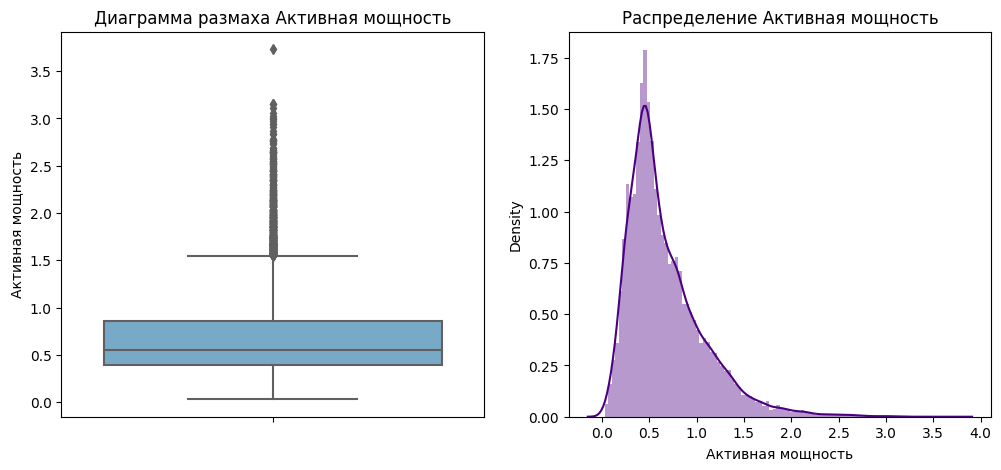

count    14876.00
mean         0.45
std          5.88
min       -715.50
25%          0.29
50%          0.42
75%          0.64
max          2.68
Name: Реактивная мощность, dtype: float64


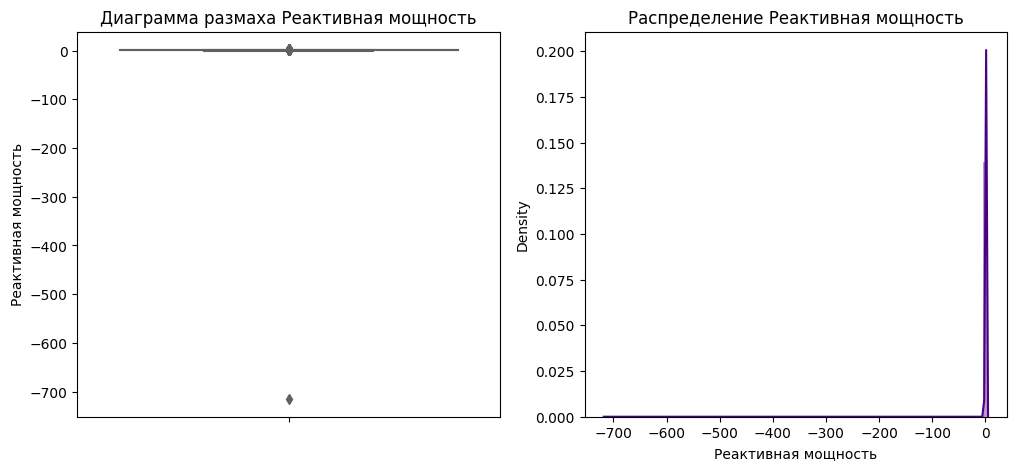

In [ ]:
float_data_analyzer(data_arc, ['Активная мощность', 'Реактивная мощность'], 100, 2)

In [ ]:
data_arc[data_arc['Реактивная мощность'] < -100]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [ ]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


#### **Сыпучие добавки**

count     25.00
mean     305.60
std      191.02
min       47.00
25%      155.00
50%      298.00
75%      406.00
max      772.00
Name: Bulk 7, dtype: float64


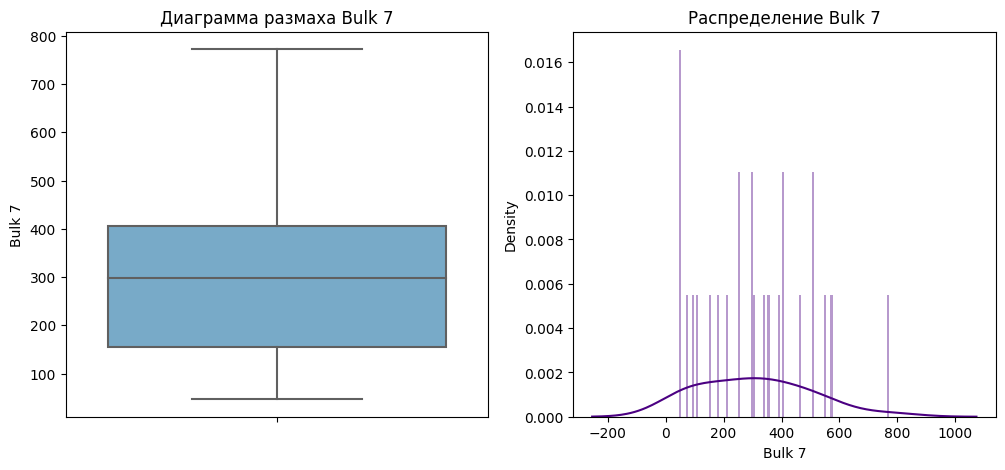

count    2248.00
mean      160.51
std        51.77
min         1.00
25%       105.00
50%       160.00
75%       205.00
max       405.00
Name: Bulk 15, dtype: float64


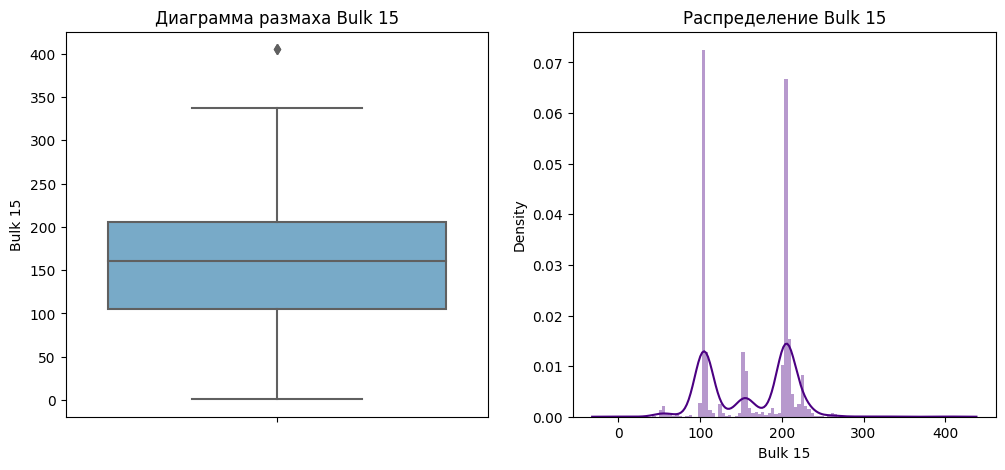

count    176.00
mean      83.28
std       26.06
min       24.00
25%       64.00
50%       86.50
75%      102.00
max      159.00
Name: Bulk 10, dtype: float64


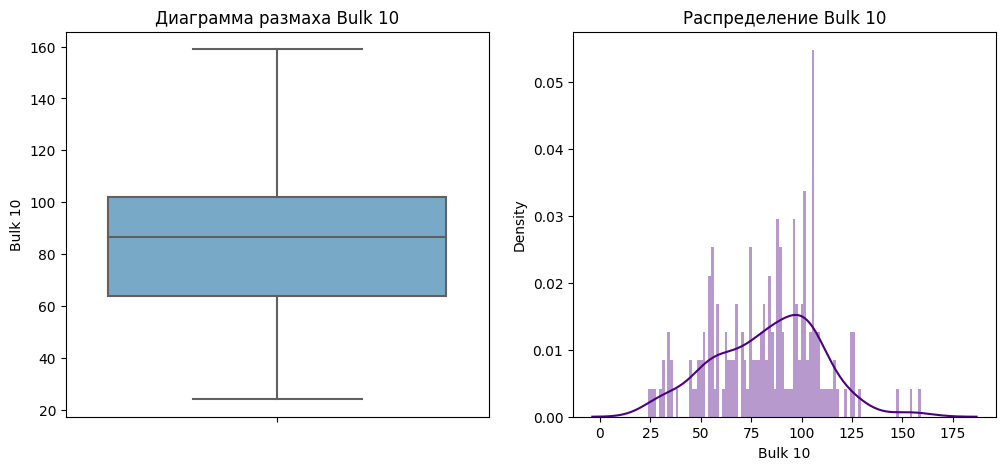

count    177.00
mean      76.82
std       59.66
min        8.00
25%       25.00
50%       64.00
75%      106.00
max      313.00
Name: Bulk 11, dtype: float64


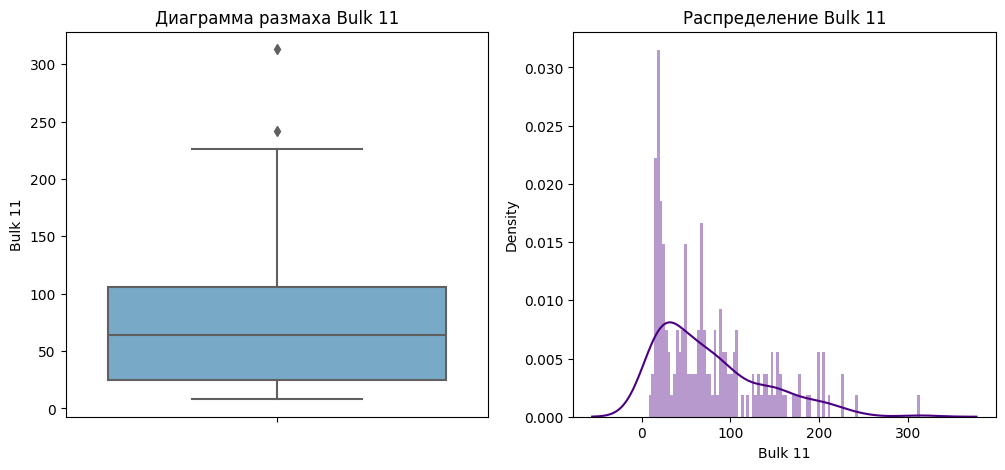

count    576.00
mean     118.93
std       72.06
min       17.00
25%       69.75
50%      100.00
75%      157.00
max      503.00
Name: Bulk 6, dtype: float64


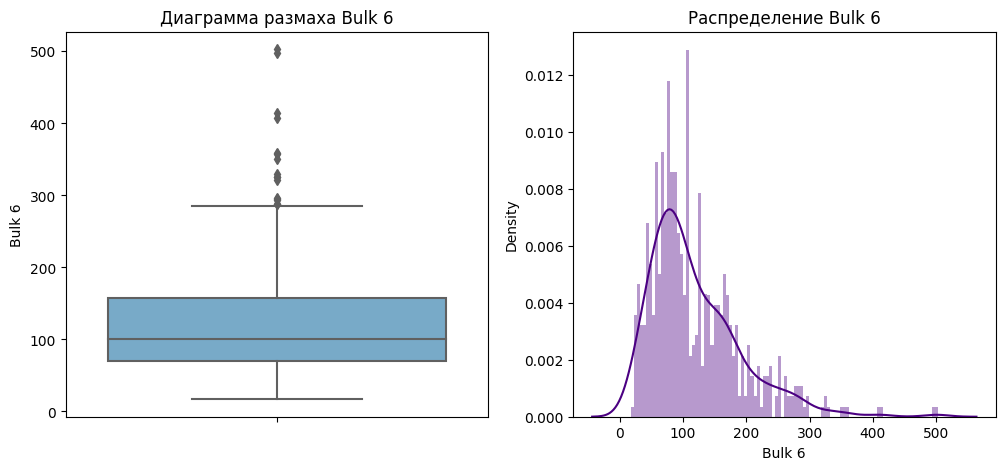

count    1298.00
mean      113.88
std        75.48
min         6.00
25%        58.00
50%        97.50
75%       152.00
max       454.00
Name: Bulk 3, dtype: float64


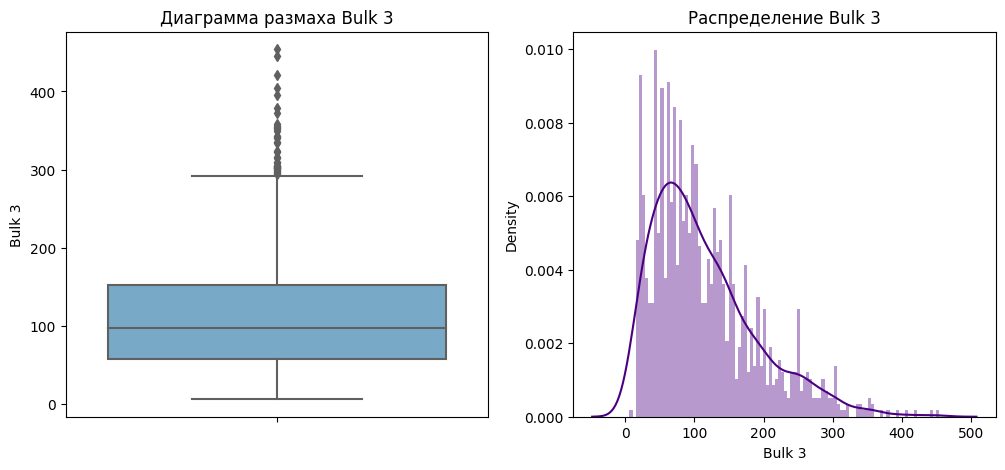

count    2806.00
mean      170.28
std        65.87
min        16.00
25%       119.00
50%       151.00
75%       205.75
max       636.00
Name: Bulk 14, dtype: float64


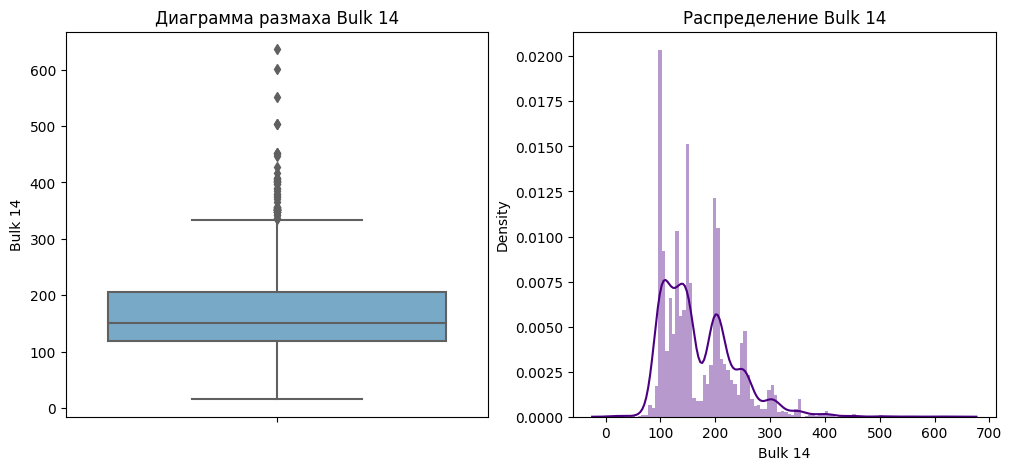

count     18.00
mean     181.11
std       46.09
min      151.00
25%      153.25
50%      155.50
75%      203.50
max      305.00
Name: Bulk 13, dtype: float64


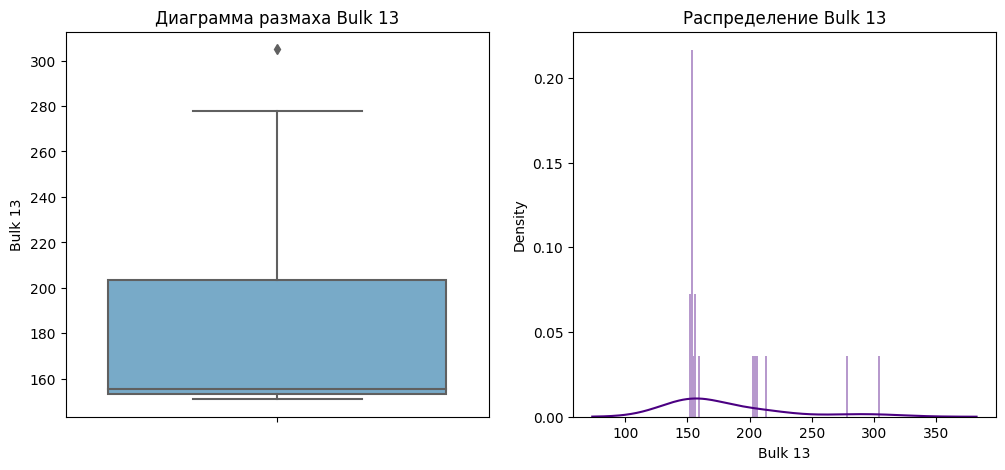

count    1014.00
mean      104.39
std        48.18
min        12.00
25%        72.00
50%       102.00
75%       133.00
max       281.00
Name: Bulk 4, dtype: float64


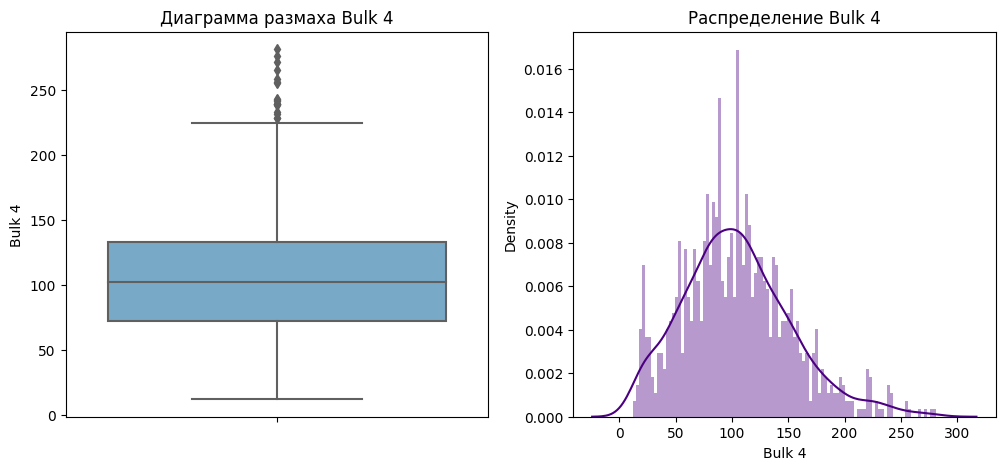

count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64


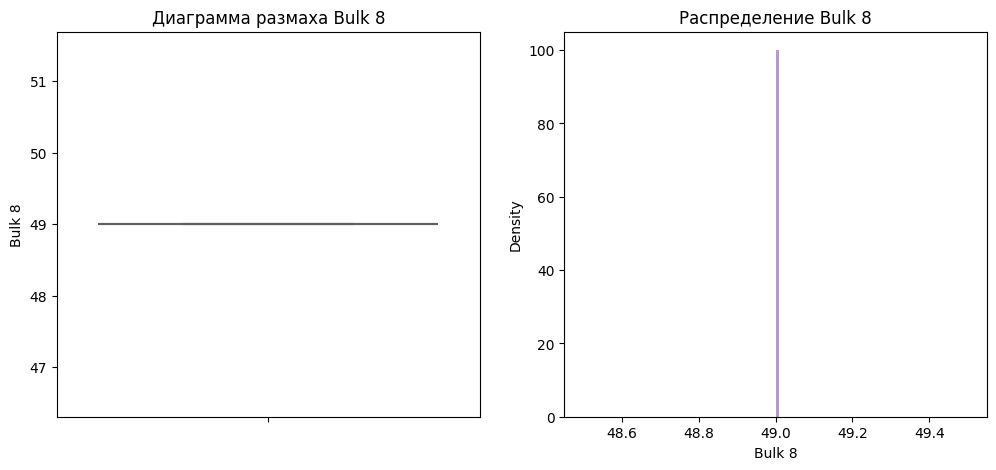

count     77.00
mean     107.03
std       81.79
min       11.00
25%       70.00
50%       86.00
75%      132.00
max      603.00
Name: Bulk 5, dtype: float64


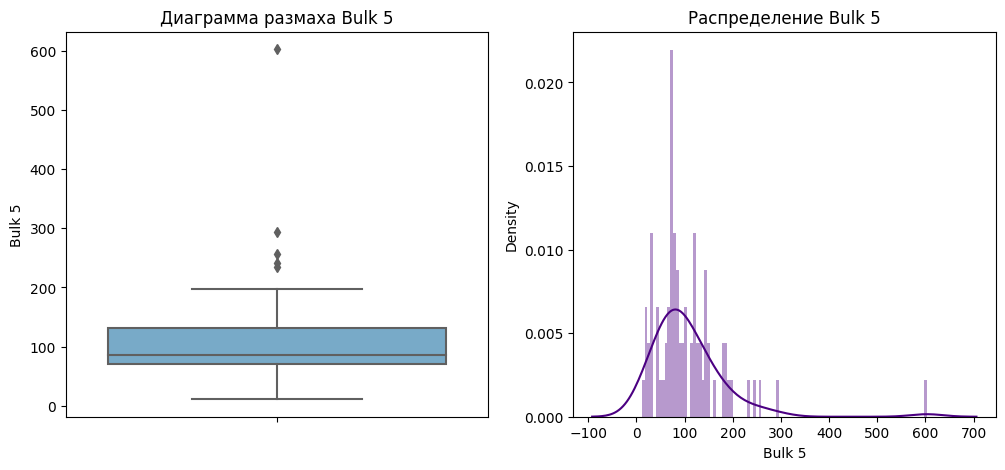

count     22.00
mean     253.05
std       21.18
min      228.00
25%      242.00
50%      251.50
75%      257.75
max      325.00
Name: Bulk 2, dtype: float64


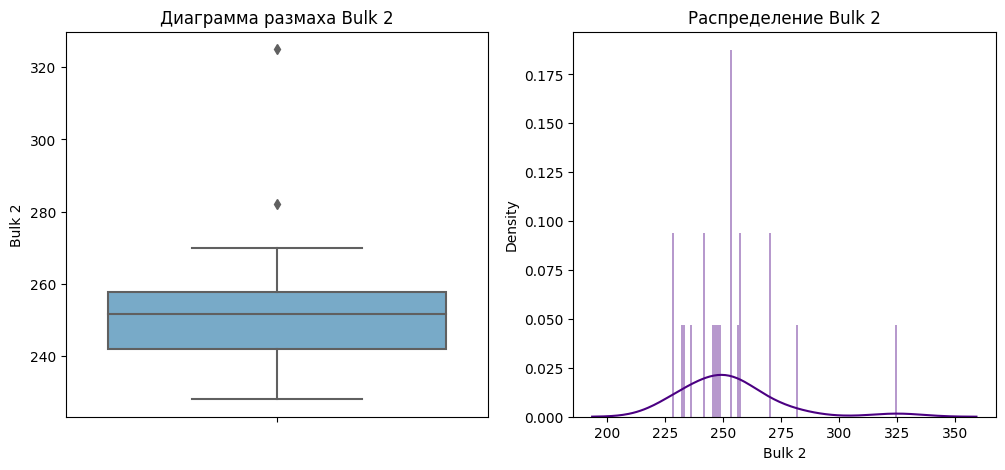

count    252.00
mean      39.24
std       18.28
min       10.00
25%       27.00
50%       31.00
75%       46.00
max      185.00
Name: Bulk 1, dtype: float64


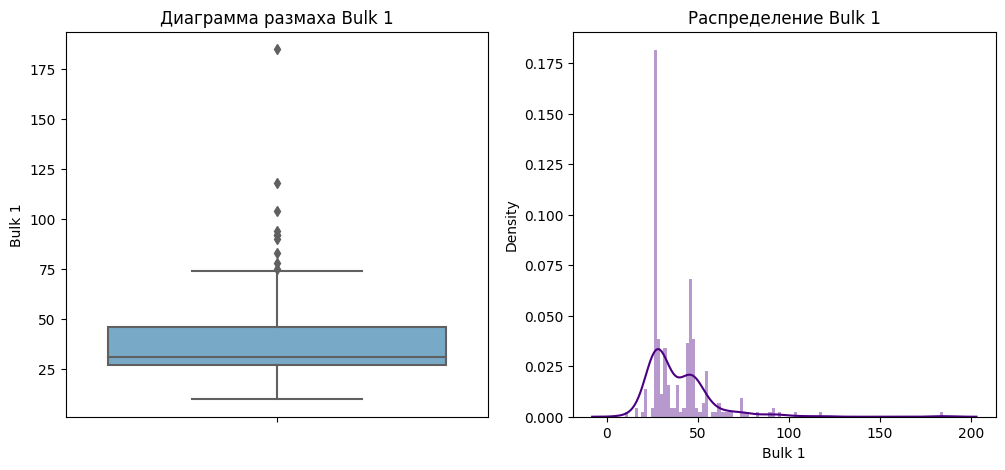

count     19.00
mean      76.32
std       21.72
min       63.00
25%       66.00
50%       68.00
75%       70.50
max      147.00
Name: Bulk 9, dtype: float64


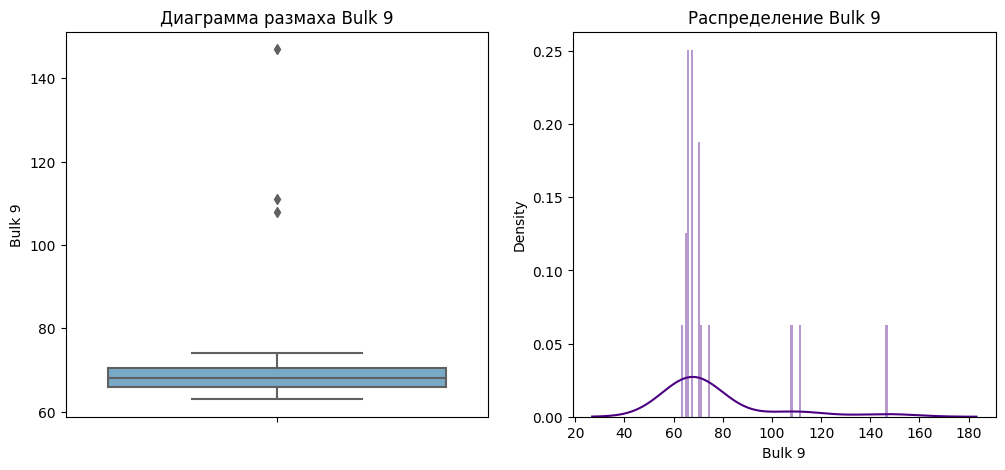

count    2450.00
mean      260.47
std       120.65
min        53.00
25%       204.00
50%       208.00
75%       316.00
max      1849.00
Name: Bulk 12, dtype: float64


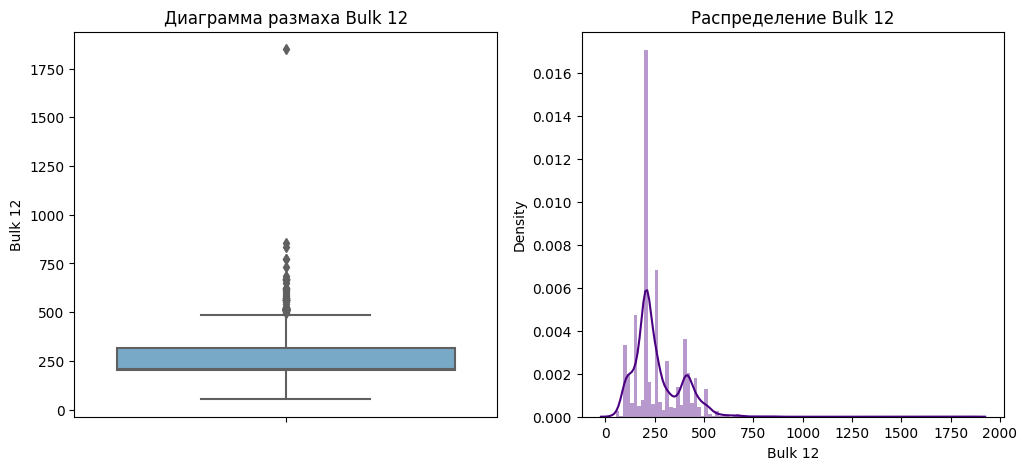

In [ ]:
bulk_columns = list(set(data_bulk_time.columns).difference(['key']))
float_data_analyzer(data_bulk, bulk_columns, 100, 2)

#### **Проволочные добавки**

count    3055.00
mean      100.90
std        42.01
min         1.92
25%        72.12
50%       100.16
75%       126.06
max       330.31
Name: Wire 1, dtype: float64


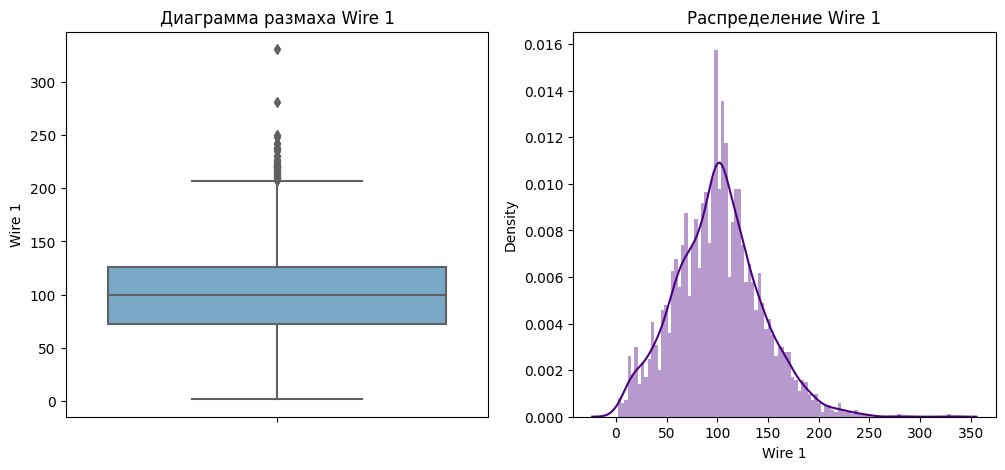

count     1.00
mean     15.13
std        NaN
min      15.13
25%      15.13
50%      15.13
75%      15.13
max      15.13
Name: Wire 5, dtype: float64


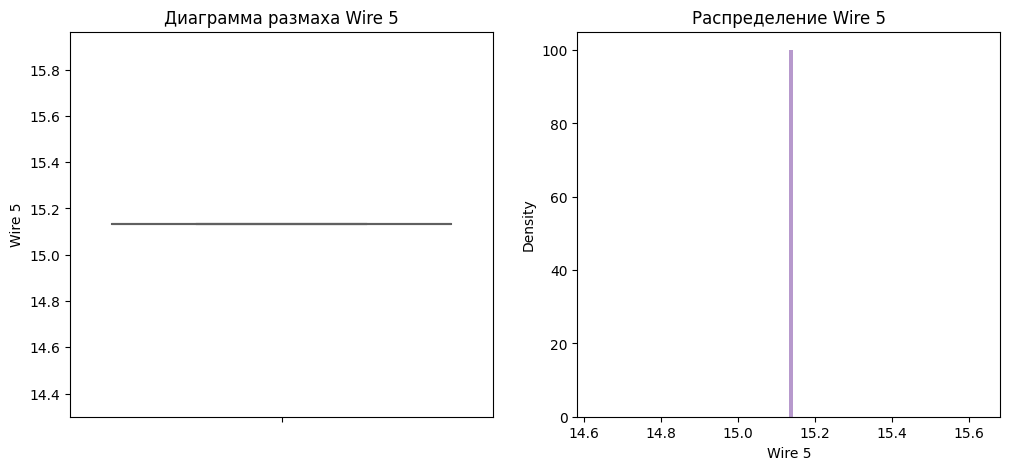

count     63.00
mean     189.48
std       99.51
min        0.14
25%       95.14
50%      235.19
75%      276.25
max      385.01
Name: Wire 3, dtype: float64


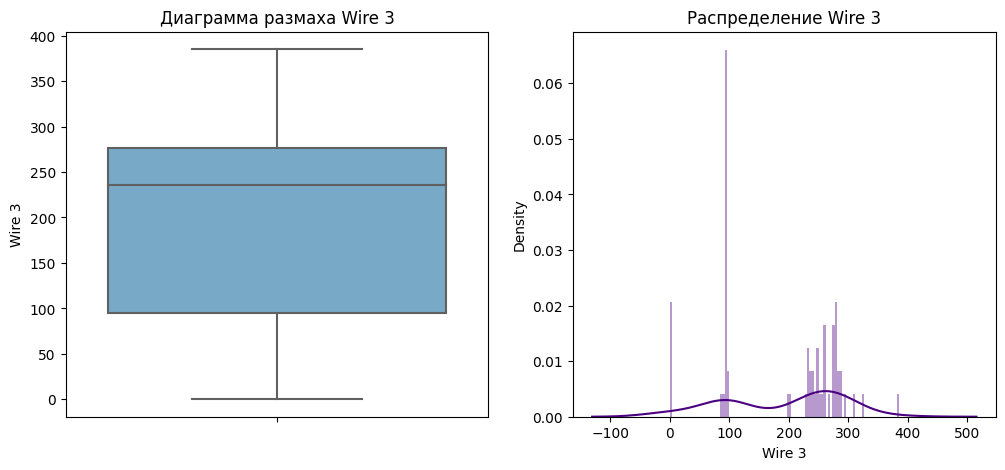

count    1079.00
mean       50.58
std        39.32
min         0.03
25%        20.19
50%        40.14
75%        70.23
max       282.78
Name: Wire 2, dtype: float64


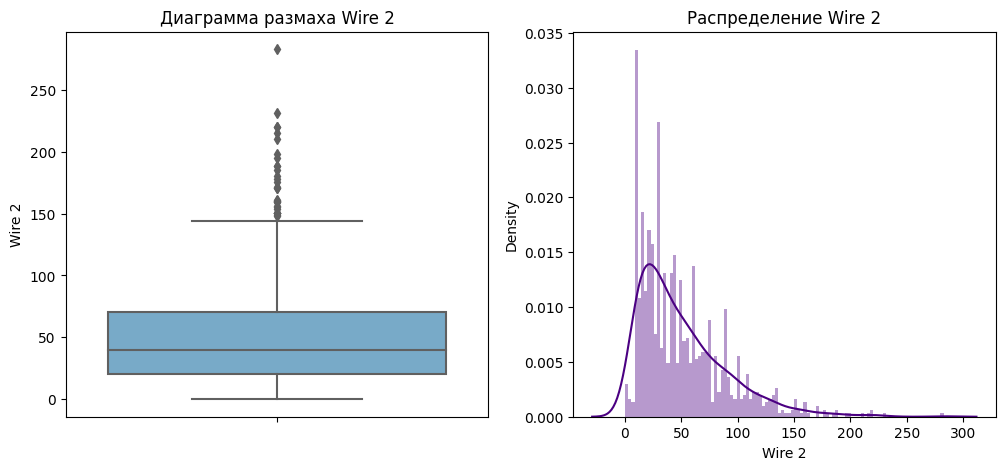

count     73.00
mean      48.02
std       33.92
min        0.03
25%       25.05
50%       42.08
75%       64.21
max      180.45
Name: Wire 6, dtype: float64


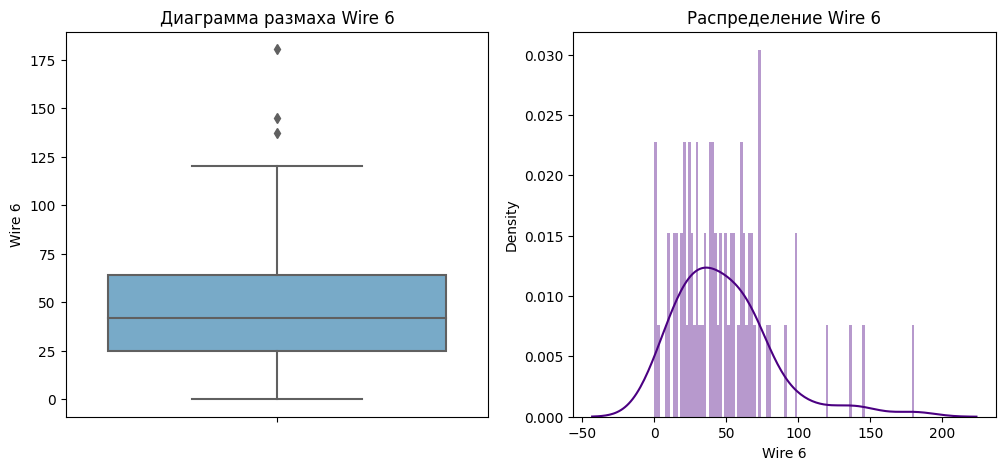

count     14.00
mean      57.44
std       28.82
min       24.15
25%       40.81
50%       45.23
75%       76.12
max      113.23
Name: Wire 4, dtype: float64


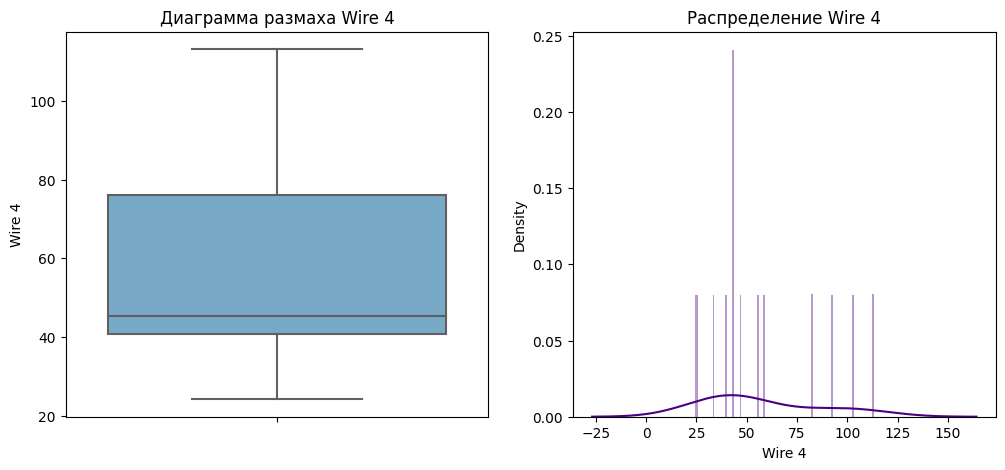

count    29.00
mean     34.16
std      19.93
min       4.62
25%      22.06
50%      30.07
75%      43.86
max      90.05
Name: Wire 9, dtype: float64


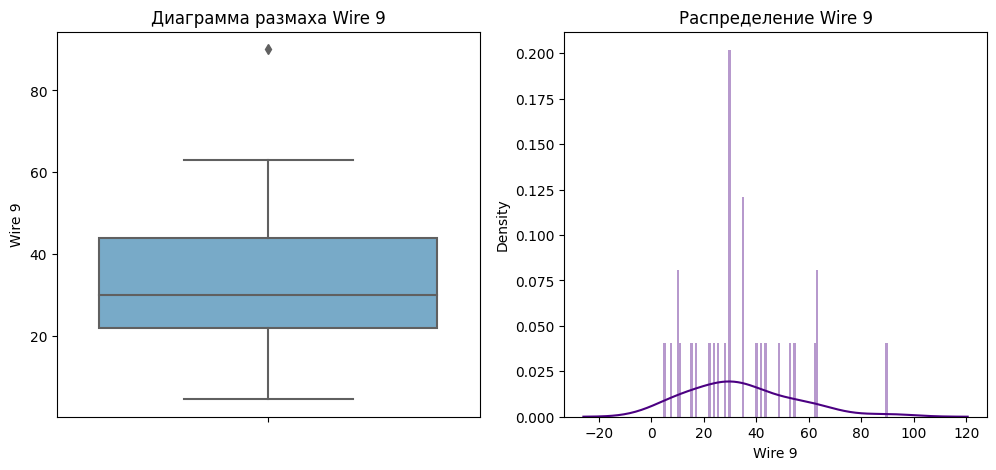

count    11.00
mean     10.04
std       8.61
min       0.23
25%       6.76
50%       9.02
75%      11.89
max      32.85
Name: Wire 7, dtype: float64


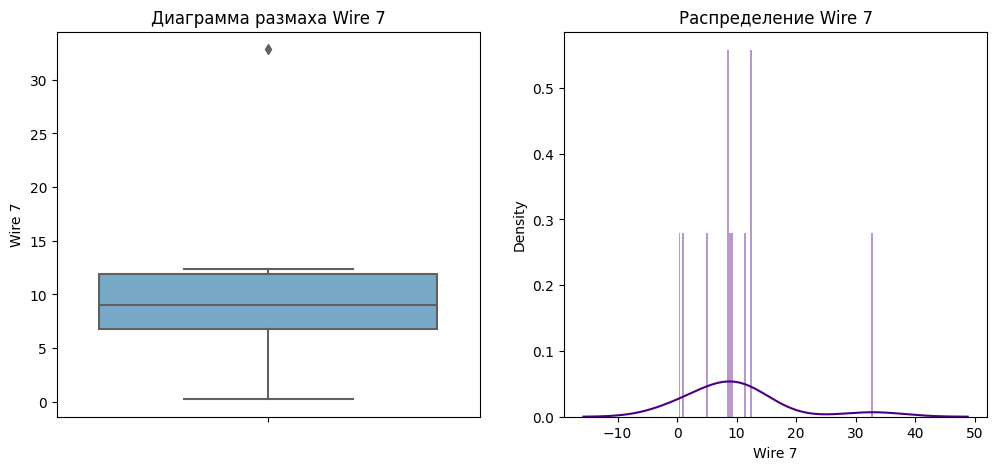

count     19.00
mean      53.63
std       16.88
min       45.08
25%       46.09
50%       46.28
75%       48.09
max      102.76
Name: Wire 8, dtype: float64


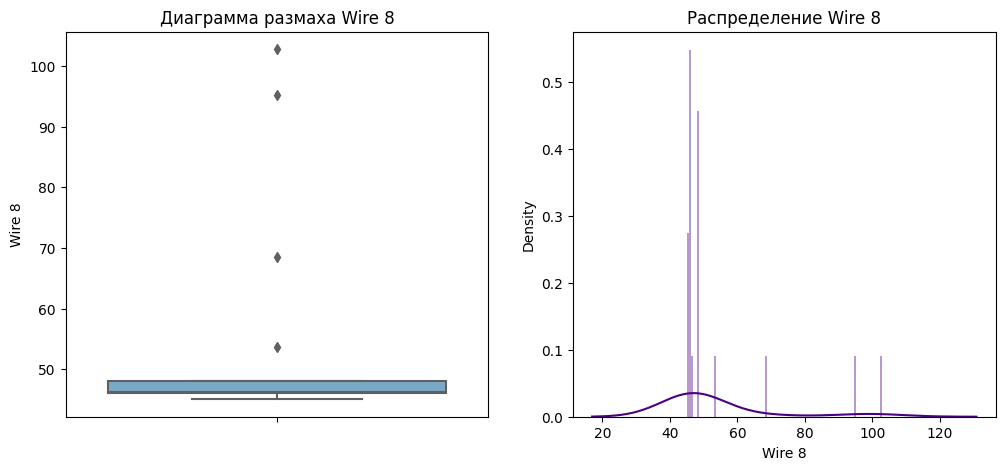

In [ ]:
wire_columns = list(set(data_wire_time.columns).difference(['key']))
float_data_analyzer(data_wire, wire_columns, 100, 2)

#### **Продувочный газ**

count    3239.00
mean       11.00
std         6.22
min         0.01
25%         7.04
50%         9.84
75%        13.77
max        78.00
Name: Газ 1, dtype: float64


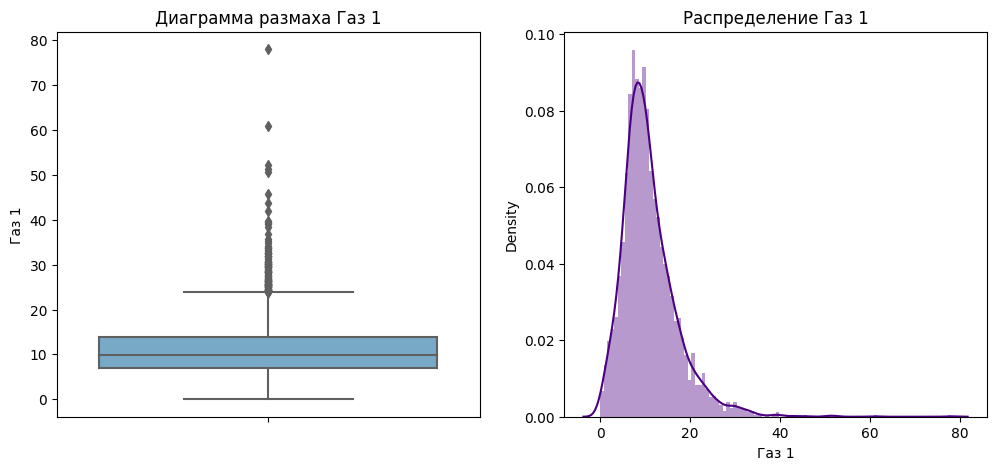

In [ ]:
float_data_analyzer(data_gas, ['Газ 1'], 100, 2)

#### **Температура**

count    13006.00
mean      1591.84
std         21.38
min       1191.00
25%       1581.00
50%       1591.00
75%       1601.00
max       1705.00
Name: Температура, dtype: float64


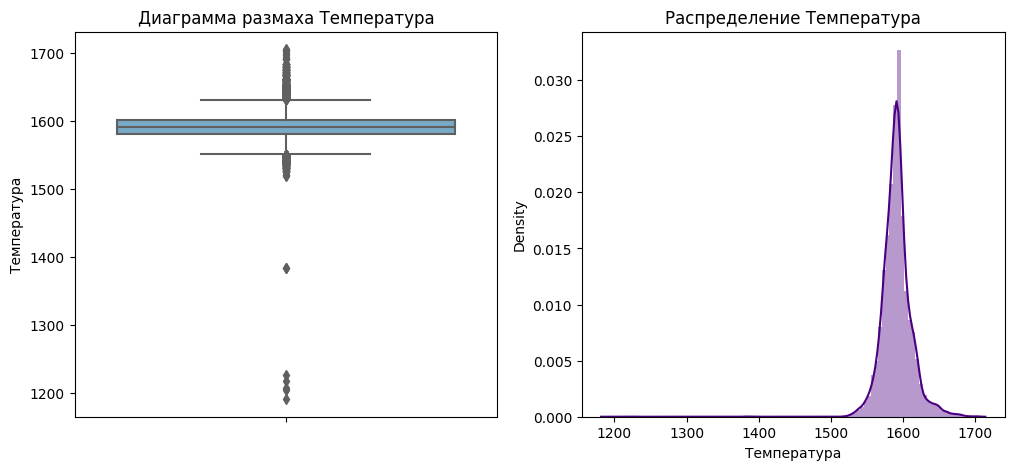

In [ ]:
float_data_analyzer(data_temp, ['Температура'], 100, 2)

## 2.5 Вывод

В данных много пропусков (таблицы **data_bulk**, **data_bulk_time**, **data_temp**, **data_wire**, **data_wire_time**), особенно в таблицах **data_bulk**, **data_bulk_time**, **data_wire**, **data_wire_time**.

Вероятные причины появления пропусков для data_bulk, data_bulk_time, data_wire, data_wire_time: каждому столбцу 'Wire' и 'Bulk' соответствует стадия подачи какого-либо вида проволочных или сыпучих материалов; пропуск означает, что на данной стадии в партию не добавлялись те или иные проволочные или сыпучие добавки.

Кроме того, пропуски присутствуют в столбце 'Температура' в таблице **data_emp**. Данный признак является целевым для разрабатываемой модели, однако следует учесть следующие моменты:
- целевыми являются только последние (финальные) показатели температур для каждой партии;
- для использования (обучения) доступны только начальные показатели температур для каждой партии: промежуточные значения температур использовать нельзя т.к. ***они не могут быть доступны обученной модели перед предсказанием.***



Стоит отметить, что количество партий в таблицах разнится от 3081 до 3239. Возможно это связано с тем, что некоторые партии не легировались примесями.

При этом температурные измерения доступны только для 3216 партий.

При анализе реактивной мощности обнаружено аномальное значение в -715 единиц. С точки зрения физики, реактивная мощность может принимать отрицательные значения, однако на фоне других значений в выборке, данный показатель выглядит выпадающим. Предлагается к удалению.

Остальные величины в целом выглядят в целом "нормально".

# 3. План работы

После проведённого анализа данных можно составить дальнейший план работы. Для удобства в план также добавлены уже сделанные этапы.

## 3.1 План

1. **Ознакомление с данными и EDA.**
- Ознакомление с тех. процессом.
- Импорт данных, первичный анализ, вывод.
- Отправка план на проверку тимлиду, получение обратной связи от тимлида, внесение возможных корректив в план.

2. **Подготовка данных.**
- Приведение типов (представить дату в формате datetime).
- Отбор данных: нахождение пригодных для обучения партии, объединение таблиц, выделение целевого признака, удаление аномалий, заполнение пропусков.
- Разбиение данных на подвыборки для обучения моделей (train, ~~~valid,~~ test).

Предлагается рассмотреть несколько моделей, начиная с наиболее простых (решающее дерево, линейная регрессия, случайный лес). В случае, если необходимое качество не будет достигнуто, или же время обучения будет неоправданно высоким, то предлагается опробовать более сложные модели (LightGBM, CatBoost).

3. **Обучение моделей.**
- Обучение моделей, валидация, тестирование, подведение результатов в формате : модель | значение метрики качества | время обучения. Построение графика зависимости качества модели от времени обучения. Чем ближе точка, соответствующая модели, к началу координат, тем модель лучше.
- Отправка работы на проверку ревьюеру, получение обратной связи от ревьюера, внесение возможных изменений в работу, после получения одобрения ревьюера — написание отчёта.

4. **Сдача проекта.**
- Отправка план на проверку тимлиду, получение обратной связи от тимлида, возможная доработка проекта.




# 4. Подготовка данных

## 4.1 Приведение типов



In [ ]:
# Data_arc fix.
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')


# Data_temp fix.
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')


# Data_bulk_time fix.
for column in bulk_columns:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column], format='%Y-%m-%d %H:%M:%S')
del bulk_columns


# Data_wire_time fix.
for column in wire_columns:
    data_wire_time[column] = pd.to_datetime(data_wire_time[column], format='%Y-%m-%d %H:%M:%S')
del wire_columns, column

In [ ]:
# Types after fixing.
for data, name in zip([data_arc, data_temp, data_bulk_time, data_wire_time],
                      ['data_arc', 'data_temp', 'data_bulk_time', 'data_wire_time']):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Таблица:', name)
    print('Типы данных:')
    print(data.info())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Таблица: data_arc
Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Таблица: data_temp
Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data

## 4.2 Отбор данных

### 4.2.1 Температурные признаки

Поскольку есть ограничения по температурных данных, необходимо подробнее рассмотреть связанные с ними таблицы. Требуется извлечь два значения температуры для каждой партии: начальную (признак) и конечную (целевой признак).

In [ ]:
# Temp-key stat.
temp_key_stat = pd.pivot_table(data_temp, index='key', values='Температура', aggfunc='count')
temp_key_stat.columns = ['measurment_counts']
temp_key_stat = temp_key_stat.sort_values(by='measurment_counts', ascending=True)
temp_key_stat

,measurment_counts
key,
3241,1
2809,1
2808,1
2807,1
2806,1
...,...
1689,15
46,16
1513,16


In [ ]:
print('Количество партий с менее чем двумя измерениями температуры:', temp_key_stat[temp_key_stat['measurment_counts'] < 2].shape[0])

Количество партий с менее чем двумя измерениями температуры: 741


Партии с менее чем двумя измерениями температуры использовать для обучения не получится. Поэтому предлагается удалить их из выборки.

In [ ]:
# Creating list with keys of 'wrong' parties.
drop_list = list(temp_key_stat[temp_key_stat['measurment_counts'] < 2].index)

# Append anomal-power party.
drop_list.append(2116)

In [ ]:
temp_key_stat.drop(temp_key_stat[temp_key_stat['measurment_counts'] < 2].index, inplace=True)
print('Количество партий с двумя и более измерениями температуры:', temp_key_stat.shape[0])

Количество партий с двумя и более измерениями температуры: 2475


In [ ]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [ ]:
# Data_temp cleaning.
data_temp.drop(data_temp[data_temp['key'].isin(drop_list)].index, inplace=True)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12261 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12261 non-null  int64         
 1   Время замера  12261 non-null  datetime64[ns]
 2   Температура   12261 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.2 KB


In [ ]:
# Data cleaning.
for data in [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]:
    data.drop(data[data['key'].isin(drop_list)].index, inplace=True)

# Data after fixing.
for data, name in zip([data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time],
                      ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Таблица:', name)
    print('Количество данных:')
    print(data.info())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

del data, name

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Таблица: data_arc
Количество данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11445 entries, 0 to 11448
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   11445 non-null  int64         
 1   Начало нагрева дугой  11445 non-null  datetime64[ns]
 2   Конец нагрева дугой   11445 non-null  datetime64[ns]
 3   Активная мощность     11445 non-null  float64       
 4   Реактивная мощность   11445 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 536.5 KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Таблица: data_bulk
Количество данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2406 entries, 0 to

Для оставшихся партий можно провести извлечение начальной и конечной температур.

In [ ]:
# Time of first & last measurment.
data_common = pd.pivot_table(data_temp, index=['key'], values='Время замера', aggfunc=['min', 'max'])
data_common.columns = ['Время замера', 'last_time']
data_common.head(1)

,Время замера,last_time
key,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39


In [ ]:
# Extracting first temperature.
data_common = data_common.merge(data_temp, on='Время замера', how='left')
data_common.head(1)

,Время замера,last_time,key,Температура
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,1571.0


In [ ]:
# Set new column names for merge.
data_common.columns = ['first_time', 'Время замера', 'key', 'first_temp']
data_common.head(1)

,first_time,Время замера,key,first_temp
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,1571.0


In [ ]:
# Extracting last temperature.
data_common = data_common.merge(data_temp.drop('key', axis=1), on='Время замера', how='left')
data_common.head(1)

,first_time,Время замера,key,first_temp,Температура
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,1571.0,1613.0


In [ ]:
# Set correct column names.
data_common.columns = ['first_time', 'last_time', 'key', 'first_temp', 'last_temp']
data_common.head(1)

,first_time,last_time,key,first_temp,last_temp
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,1571.0,1613.0


In [ ]:
def session_time_calculation(row):
    first_time = row['first_time']
    last_time = row['last_time']

    time = pd.Timedelta(last_time - first_time, unit='sec').total_seconds()
    return time

In [ ]:
# Features compression.
data_common['session_time'] = data_common.apply(session_time_calculation, axis=1)

In [ ]:
data_common.drop(columns=['first_time', 'last_time'], inplace=True)
data_common

,key,first_temp,last_temp,session_time
0,1,1571.0,1613.0,861.0
1,2,1581.0,1602.0,1305.0
2,3,1596.0,1599.0,1300.0
3,4,1601.0,1625.0,388.0
4,5,1576.0,1602.0,762.0
...,...,...,...,...
2469,2495,1570.0,1591.0,1137.0
2470,2496,1554.0,1591.0,1618.0
2471,2497,1571.0,1589.0,717.0
2472,2498,1591.0,1594.0,1302.0


### 4.2.2 Энергетические признаки

count    11445.00
mean         0.68
std          0.41
min          0.03
25%          0.40
50%          0.56
75%          0.86
max          3.73
Name: Активная мощность, dtype: float64


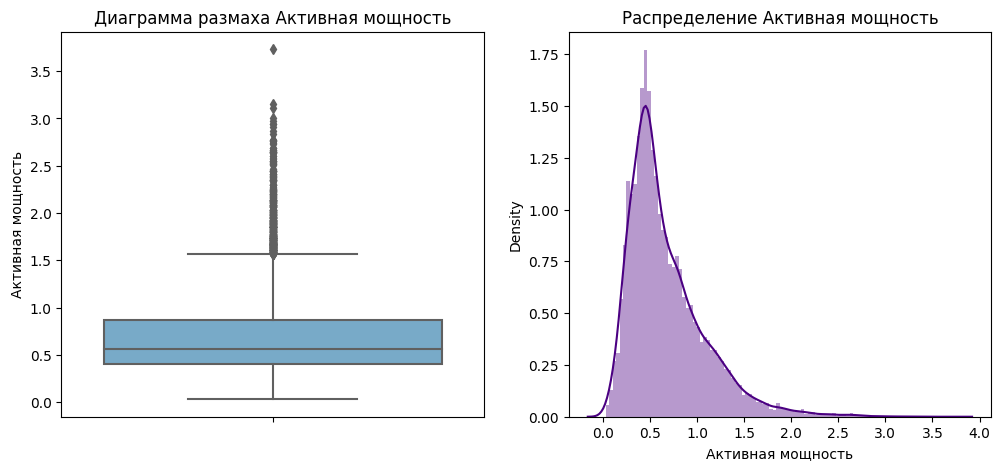

count    11445.00
mean         0.50
std          0.31
min          0.02
25%          0.29
50%          0.42
75%          0.65
max          2.68
Name: Реактивная мощность, dtype: float64


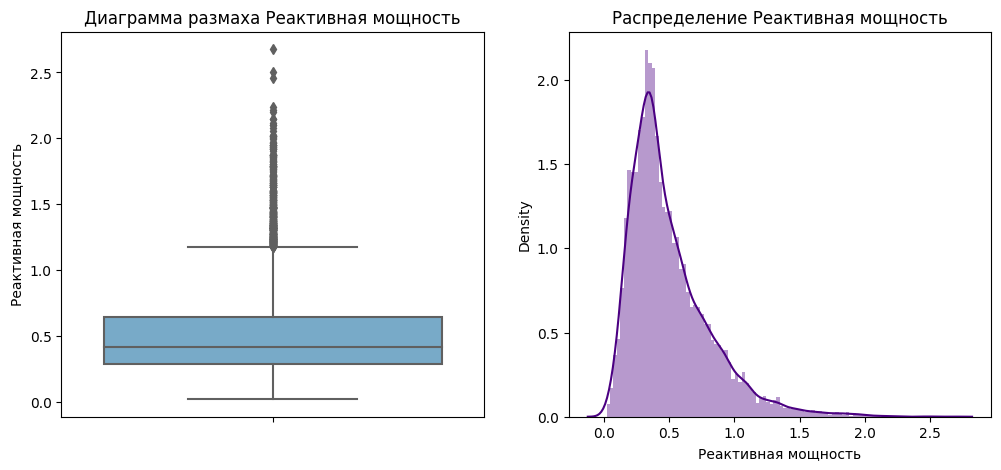

In [ ]:
float_data_analyzer(data_arc, ['Активная мощность', 'Реактивная мощность'], 100, 2)

[Мо́щность](https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C)  — скалярная физическая величина, равная в общем случае скорости изменения, преобразования, передачи или потребления энергии системы. В более узком смысле мощность равна отношению работы, выполняемой за некоторый промежуток времени, к этому промежутку времени.


Полную мощность можно разделить на две составляющие: активную и реактивную. Активная мощность в условиях задачи отвечает за нагрев стали, а реактивная за потери энергии. Указанные величины связаны соотношением:

$
S = \sqrt{P^2 + Q^2},
$ (1)

где $P$ — активная мощность, а $Q$ — реактивная мощность (при индуктивной нагрузке $Q>0$, а при ёмкостной $Q<0$).

Работа (или энергия) и мощность [связаны](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F_%D0%BF%D0%BE_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%B8) следующей формулой:

$
A = \int\limits_0^T{Pdt},
$ (2)

где $A$ — работа, a $T$ — время, за которое совершалась работа.


In [ ]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.9634718732173795

Показатели активной и реактивной мощности имеют сильную степень корреляции. Предлагается объединить данные два признака в один с помощью первой вышеуказанной формулой, а также связать с известными временными показателями с помощью второй формулы.

In [ ]:
def energy_calculation(row):
    first_time = row['Начало нагрева дугой']
    last_time = row['Конец нагрева дугой']
    active_power = row['Активная мощность']
    reactive_power = row['Реактивная мощность']

    time = pd.Timedelta(last_time - first_time, unit='sec').total_seconds()
    full_power = (active_power**2 + reactive_power**2)**0.5
    energy = full_power * time
    return energy

In [ ]:
# Energy calculation.
data_arc['energy'] = data_arc.apply(energy_calculation, axis=1)

In [ ]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,119.471318
...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,8.788541
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,551.247647
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,238.313354
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,485.414190


In [ ]:
# Total energy calculation.
data_energy = pd.pivot_table(data_arc, index='key', values='energy', aggfunc=['sum', 'count'])
data_energy.reset_index(level=0, inplace=True)
data_energy.columns = ['key', 'energy', 'heatings_amount']
data_energy.head()

,key,energy,heatings_amount
0,1,1442.377754,5
1,2,881.233565,4
2,3,525.066777,5
3,4,796.911309,4
4,5,1199.137958,4


In [ ]:
# Combine temperature & energetic features.
data_common = data_common.merge(data_energy, on='key', how='left')

In [ ]:
data_common.head()

,key,first_temp,last_temp,session_time,energy,heatings_amount
0,1,1571.0,1613.0,861.0,1442.377754,5
1,2,1581.0,1602.0,1305.0,881.233565,4
2,3,1596.0,1599.0,1300.0,525.066777,5
3,4,1601.0,1625.0,388.0,796.911309,4
4,5,1576.0,1602.0,762.0,1199.137958,4


In [ ]:
data_common.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 0 to 2473
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2474 non-null   int64  
 1   first_temp       2474 non-null   float64
 2   last_temp        2474 non-null   float64
 3   session_time     2474 non-null   float64
 4   energy           2474 non-null   float64
 5   heatings_amount  2474 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 135.3 KB


In [ ]:
def corr_heatmap(data, size):
    '''This function make corr-table for inputed data &
    plot heatmap on this table.
    Input:
    data — data for corr-table;
    size — tuple with sizes of heatmap.

    Output:
    heatmap of correlations.
    '''
    corr_table = data.corr().round(2)
    fig, ax = plt.subplots(1, 1, figsize=size)
    sns.heatmap(corr_table, annot=True, fmt=".2f", linewidths=.5, ax=ax)
    ax.set_title('Корреляционные зависимости признаков')
    plt.show()

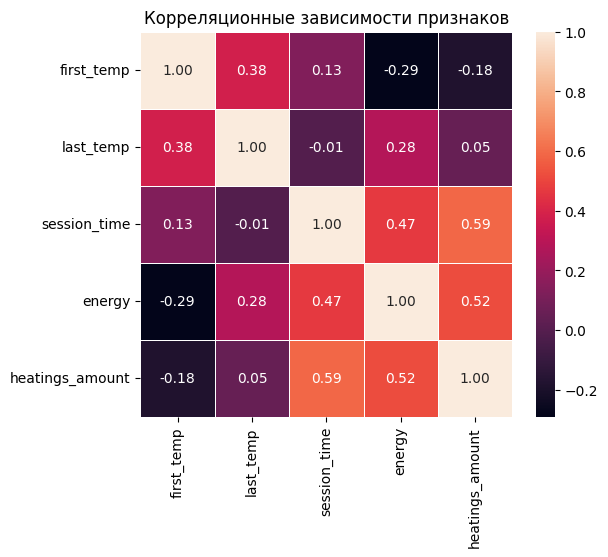

In [ ]:
corr_heatmap(data_common.drop('key', axis=1), (6, 5))

Целевой признак имеет заметные положительные корреляции с признаками 'energy' и 'first_temp'.

Также стоит отметить, что 'energy' имеет среднюю положительную корреляцию с 'session_time', что обусловлено методом рассчёта первой, и с 'heatings_amount'.

## 4.3 Объединение данных

In [ ]:
# Add gas.
data_gas.columns = ['key', 'gas']
data_common = data_common.merge(data_gas, on='key', how='left')

In [ ]:
data_common.head(1)

,key,first_temp,last_temp,session_time,energy,heatings_amount,gas
0,1,1571.0,1613.0,861.0,1442.377754,5,29.749986


In [ ]:
# Add bulk.
data_common = data_common.merge(data_bulk, on='key', how='left')

In [ ]:
data_common.head(1)

,key,first_temp,last_temp,session_time,energy,heatings_amount,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,1571.0,1613.0,861.0,1442.377754,5,29.749986,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0


In [ ]:
# Add wire.
data_common = data_common.merge(data_wire, on='key', how='left')

In [ ]:
# Set column names to lower case.
data_common.columns = (data_common.columns).str.lower()
data_common.head(1)

,key,first_temp,last_temp,session_time,energy,heatings_amount,gas,bulk 1,bulk 2,bulk 3,...,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,1571.0,1613.0,861.0,1442.377754,5,29.749986,NaN,NaN,NaN,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поскольку пропуски скорее всего означают, что для данной партии не добавлялся тот или иной тип примеси,то пропуски можно заполнить значением 0.

In [ ]:
data_common = data_common.fillna(0).drop('key', axis=1)
data_common.head()

,first_temp,last_temp,session_time,energy,heatings_amount,gas,bulk 1,bulk 2,bulk 3,bulk 4,...,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1571.0,1613.0,861.0,1442.377754,5,29.749986,0.0,0.0,0.0,43.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,1305.0,881.233565,4,12.555561,0.0,0.0,0.0,73.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,1300.0,525.066777,5,28.554793,0.0,0.0,0.0,34.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,388.0,796.911309,4,18.841219,0.0,0.0,0.0,81.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,762.0,1199.137958,4,5.413692,0.0,0.0,0.0,78.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_common.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 0 to 2473
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   first_temp       2474 non-null   float64
 1   last_temp        2474 non-null   float64
 2   session_time     2474 non-null   float64
 3   energy           2474 non-null   float64
 4   heatings_amount  2474 non-null   int64  
 5   gas              2474 non-null   float64
 6   bulk 1           2474 non-null   float64
 7   bulk 2           2474 non-null   float64
 8   bulk 3           2474 non-null   float64
 9   bulk 4           2474 non-null   float64
 10  bulk 5           2474 non-null   float64
 11  bulk 6           2474 non-null   float64
 12  bulk 7           2474 non-null   float64
 13  bulk 8           2474 non-null   float64
 14  bulk 9           2474 non-null   float64
 15  bulk 10          2474 non-null   float64
 16  bulk 11          2474 non-null   float64
 17  bulk 12       

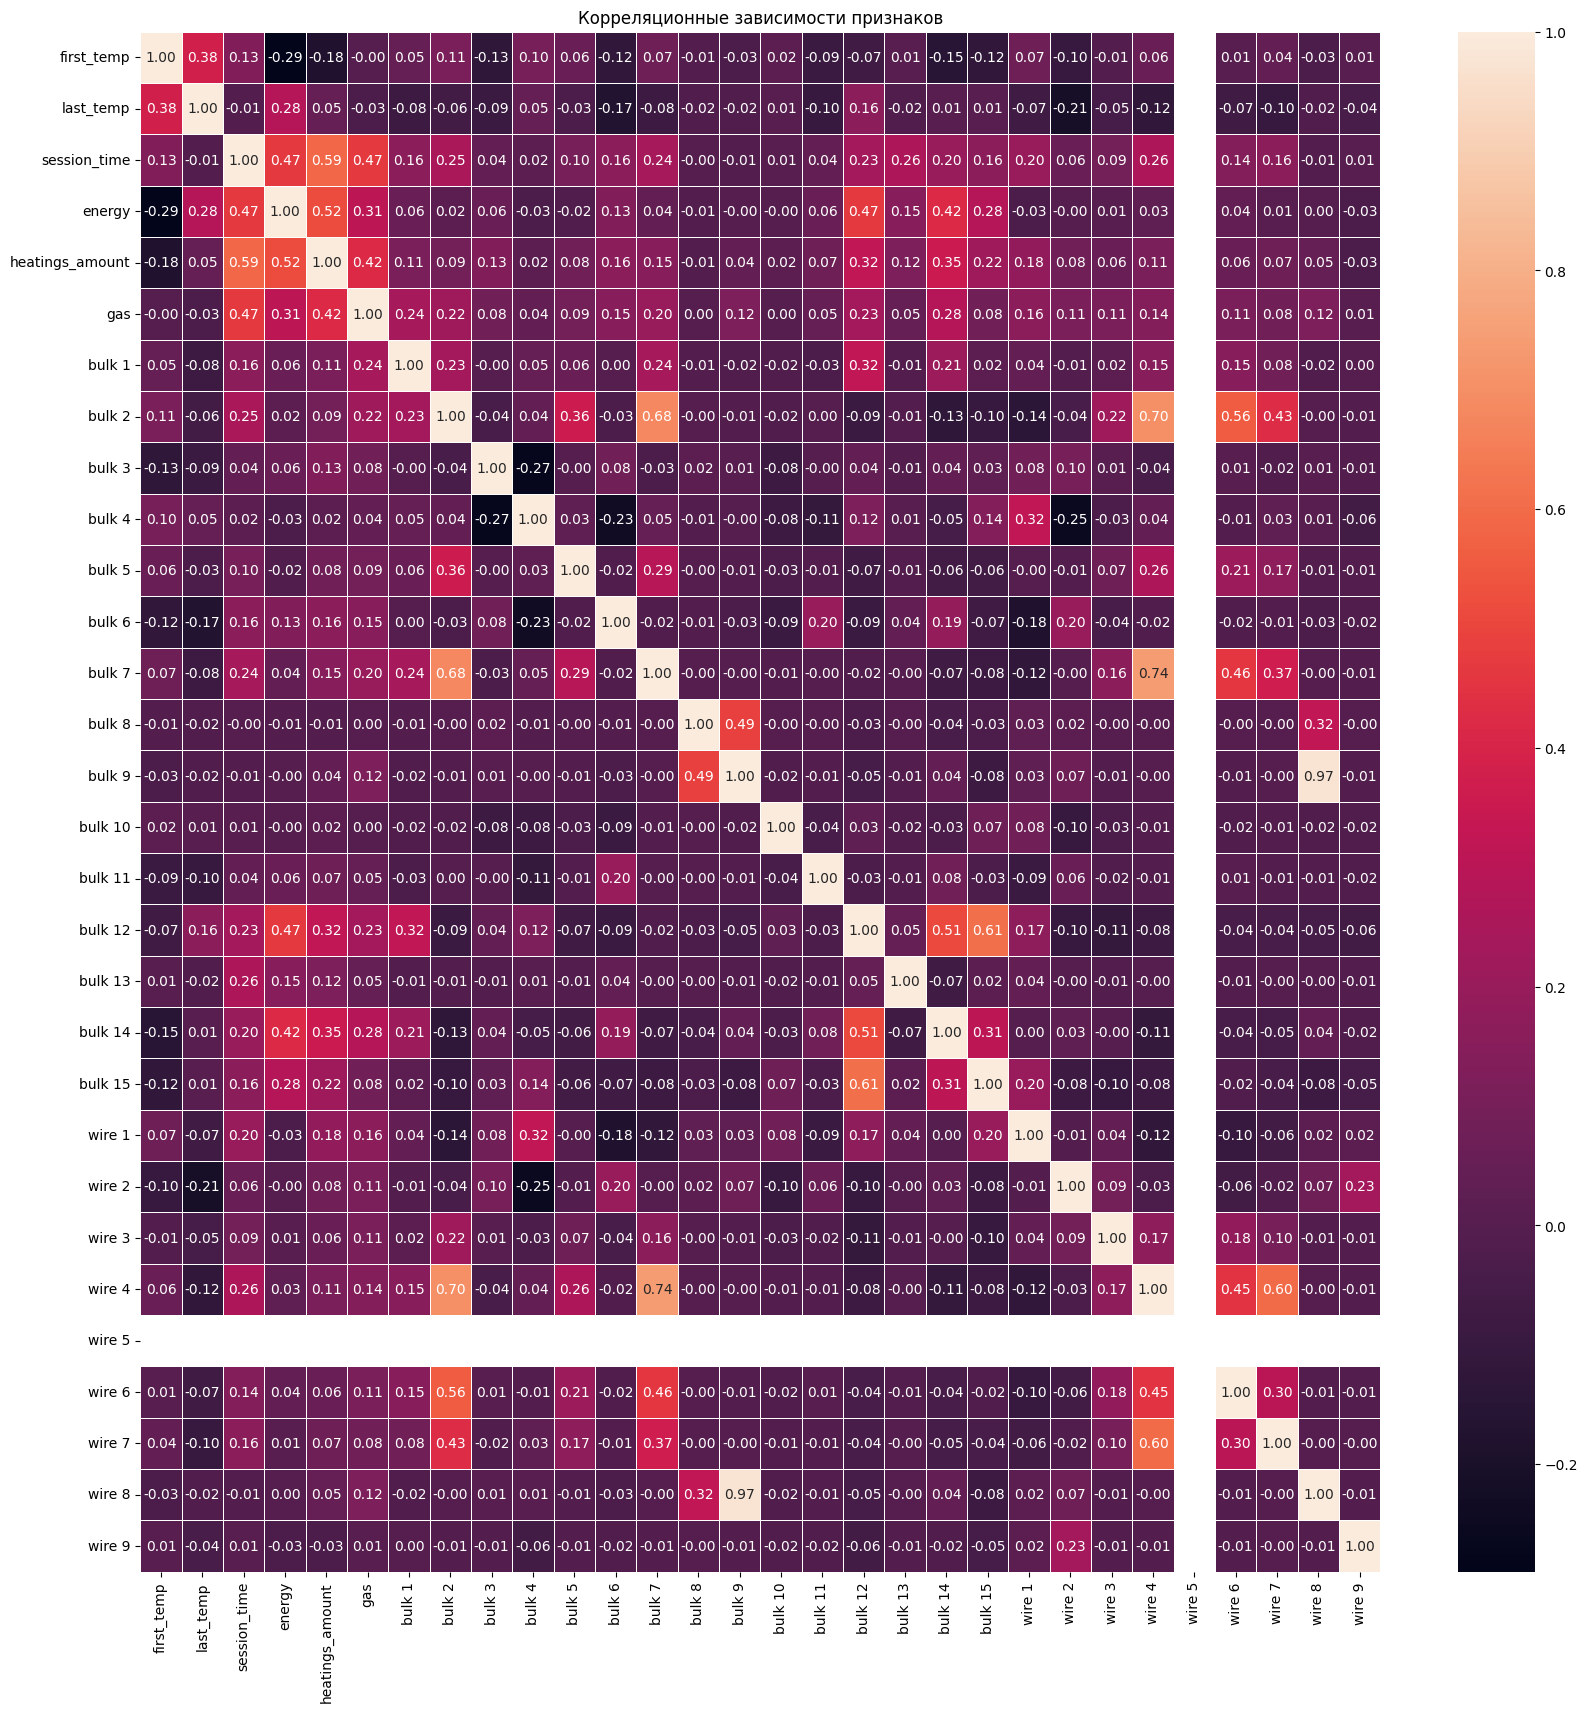

In [ ]:
corr_heatmap(data_common, (20, 20))

В целом примеси не имеют заметной корреляции с целевым признаком.

## 4.4 Кластеризация

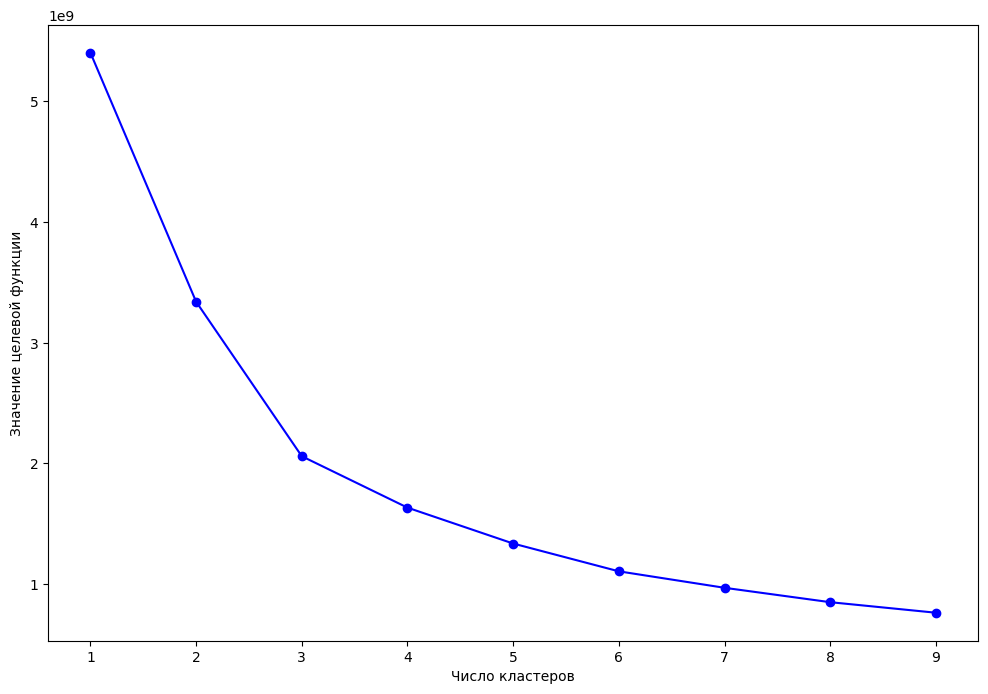

In [ ]:
from sklearn.cluster import KMeans

distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(data_common)
    distortion.append(model.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bo-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

Оптимальное число кластеров — 3.

In [ ]:
# Clustering.
model = KMeans(n_clusters=3, random_state=666)
model.fit(data_common)
centroids = pd.DataFrame(model.cluster_centers_, columns=data_common.columns)

data_common['label'] = model.labels_.astype('int')

In [ ]:
data_common.head()

,first_temp,last_temp,session_time,energy,heatings_amount,gas,bulk 1,bulk 2,bulk 3,bulk 4,...,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9,label
0,1571.0,1613.0,861.0,1442.377754,5,29.749986,0.0,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1581.0,1602.0,1305.0,881.233565,4,12.555561,0.0,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1596.0,1599.0,1300.0,525.066777,5,28.554793,0.0,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1601.0,1625.0,388.0,796.911309,4,18.841219,0.0,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1576.0,1602.0,762.0,1199.137958,4,5.413692,0.0,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## 4.5 Разбиение на подвыборки

In [ ]:
# Features & target split.
features = data_common.drop(['last_temp'], axis=1)
target = data_common['last_temp']


# Dataset split.
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25, random_state=666)

In [ ]:
print('Train')
print(features_train.shape)
print(target_train.shape)
print()
print('Test')
print(features_test.shape)
print(target_test.shape)

Train
(1855, 30)
(1855,)

Test
(619, 30)
(619,)


## 4.6 Вывод

В ходе данного этапа было удалено аномальное значение реактивной мощности, отобраны пригодные для обучения партии, получены новые энергетические признаки, данные собраны в одной таблице и избавлены от малозначащих для модели признаков('key'). Также данные были разбиты на обучающую и тестовую выборки.

Таким образом, данные подготовлены для обучения моделей.

# 5. Обучение моделей

In [ ]:
def fit_predict_score(model, features_train, target_train, features_test, target_test):
    '''This function fit inputed model on train-data, make predictions &
    return MAE-score on test-data.

    Input:
    model — model that fit & make predictions;
    features_train, features_test — data for fitting;
    target_train, target_test — data for predicting.

    Output:
    model_score — mae score on test-data.
    '''

    model.fit(features_train, target_train)
    model_predictions = model.predict(features_test)
    model_score = mean_absolute_error(target_test, model_predictions)
    print('MAE, test: {}'.format(model_score))
    return model_score

## 5.1 Решающее дерево

In [ ]:
%%time
# Creating tree-model.
model = DecisionTreeRegressor(random_state=666)

# Creating hparam grid.
parameters_grid = {'max_depth': range(2, 20, 2),
                   'min_samples_leaf': range(2, 8, 1),
                   'min_samples_split': range(2, 8, 1)}


# Creating Grid-Model.
grid_search_tree = GridSearchCV(cv=KFold(5), estimator=model, param_grid=parameters_grid,
                                scoring=make_scorer(mean_absolute_error, greater_is_better=False), n_jobs=-1)

# Fit & validate.
grid_search_tree.fit(features_train, target_train)
print(grid_search_tree.best_params_, grid_search_tree.best_score_)

{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 7} -7.2703426749504825
CPU times: user 1.29 s, sys: 181 ms, total: 1.47 s
Wall time: 24.3 s


In [ ]:
%%time
# Final tree.
tree = DecisionTreeRegressor(random_state=666, max_depth=8, min_samples_leaf=2, min_samples_split=6)
print('Дерево решений')
tree_score = fit_predict_score(tree,
                               features_train, target_train,
                               features_test, target_test)

Дерево решений
MAE, test: 7.129301170448154
CPU times: user 20.7 ms, sys: 75 µs, total: 20.7 ms
Wall time: 21.7 ms


## 5.2 Случайный лес



```python
%%time
# Creating forest-model.
model = RandomForestRegressor(random_state=666)

# Creating hparam grid.
parameters_grid = {'n_estimators': [100, 200, 300, 400],
                   'max_depth': [8],
                   'min_samples_leaf': [2],
                   'min_samples_split': [6]}

# Creating Grid-Model.
grid_search_forest = GridSearchCV(cv=KFold(5), estimator=model, param_grid=parameters_grid,
                                  scoring=make_scorer(mean_absolute_error, greater_is_better=False), n_jobs=-1, verbose=10)

# Fit & validate.
grid_search_forest.fit(features_train, target_train)
print(grid_search_forest.best_params_, grid_search_forest.best_score_)
```



```
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.0s finished
{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 400} -6.495893759839513
CPU times: user 3.75 s, sys: 17.4 ms, total: 3.77 s
Wall time: 32.7 s
```



In [ ]:
%%time
# Final forest.
print('Случайный лес')
forest = RandomForestRegressor(random_state=666, n_estimators=400, max_depth=8, min_samples_leaf=2, min_samples_split=6)
forest_score = fit_predict_score(forest,
                                 features_train, target_train,
                                 features_test, target_test)

Случайный лес
MAE, test: 6.318190783149118
CPU times: user 4.73 s, sys: 14 ms, total: 4.74 s
Wall time: 4.85 s


## 5.3 Линейная регрессия

In [ ]:
%%time
# Linear regression.
lin_reg = LinearRegression()
lin_reg_score = fit_predict_score(lin_reg,
                                  features_train, target_train,
                                  features_test, target_test)

MAE, test: 7.860347451039286
CPU times: user 16.1 ms, sys: 4.88 ms, total: 21 ms
Wall time: 27.1 ms


## 5.4 LightGBM


```python
%%time
# Create LGBM model.
gbm = lgbm.LGBMRegressor(random_state=666)


# Creating hparam grid.
parameters_grid = {
    'learning_rate': [0.01, 0.1],
    'num_iterations':[100, 1000],
    'n_estimators': [500],
    'num_leaves': range(31, 36, 1)
}

# Creating Grid-Model.
grid_search_gbm  = GridSearchCV(estimator=gbm, cv=KFold(5), param_grid=parameters_grid,
                                scoring=make_scorer(mean_absolute_error, greater_is_better=False), verbose=10, n_jobs=-1)

# Fit & validate.
grid_search_gbm .fit(features_train, target_train,
                     verbose=0)
print(grid_search_gbm.best_params_, grid_search_gbm.best_score_)
```



```
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
{'learning_rate': 0.01, 'n_estimators': 500, 'num_iterations': 1000, 'num_leaves': 33} -6.356276703088486
CPU times: user 4.49 s, sys: 259 ms, total: 4.74 s
Wall time: 1min 30s
```



In [ ]:
%%time
# LGBM.
gbm = lgbm.LGBMRegressor(random_state=666, num_leaves=33,  learning_rate=0.01, n_estimators=500, num_iterations=1000)

print('LGBM')

# Fit.
gbm.fit(features_train, target_train)

# Predict.
lgbm_prediction = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
lgbm_score = mean_absolute_error(target_test, lgbm_prediction)
# Score
print('MAE, test:', lgbm_score)

LGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 1855, number of used features: 21
[LightGBM] [Info] Start training from score 1595.186523
MAE, test: 6.068818043468809
CPU times: user 1.91 s, sys: 75.7 ms, total: 1.98 s
Wall time: 2.03 s


In [ ]:
%%time
# LGBM.
gbm = lgbm.LGBMRegressor(random_state=666, num_leaves=33,  learning_rate=0.001, n_estimators=500, num_iterations=10000)

print('LGBM')

# Fit.
gbm.fit(features_train, target_train)

# Predict.
lgbm_prediction = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
lgbm_score = mean_absolute_error(target_test, lgbm_prediction)
# Score
print('MAE, test:', lgbm_score)

LGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 1855, number of used features: 21
[LightGBM] [Info] Start training from score 1595.186523
MAE, test: 6.047504984924707
CPU times: user 16.6 s, sys: 696 ms, total: 17.3 s
Wall time: 17.4 s


## 5.5 Catboost

In [ ]:
%%time
# Default cat.
print('CatBoost')
cat = CatBoostRegressor(random_seed=777, loss_function='MAE')
cat_score = fit_predict_score(cat, features_train, target_train, features_test, target_test)

CatBoost
0:	learn: 9.7199020	total: 51.9ms	remaining: 51.8s
1:	learn: 9.6179615	total: 55.7ms	remaining: 27.8s
2:	learn: 9.5257972	total: 59.7ms	remaining: 19.8s
3:	learn: 9.4343503	total: 63.3ms	remaining: 15.8s
4:	learn: 9.3486516	total: 67ms	remaining: 13.3s
5:	learn: 9.2505115	total: 70.6ms	remaining: 11.7s
6:	learn: 9.1881056	total: 74.5ms	remaining: 10.6s
7:	learn: 9.1201132	total: 78.1ms	remaining: 9.68s
8:	learn: 9.0440913	total: 83.1ms	remaining: 9.14s
9:	learn: 8.9808163	total: 86.7ms	remaining: 8.58s
10:	learn: 8.9076654	total: 90.6ms	remaining: 8.14s
11:	learn: 8.8427311	total: 93.9ms	remaining: 7.73s
12:	learn: 8.7826552	total: 97.2ms	remaining: 7.38s
13:	learn: 8.7171698	total: 101ms	remaining: 7.1s
14:	learn: 8.6657827	total: 104ms	remaining: 6.83s
15:	learn: 8.6135202	total: 107ms	remaining: 6.61s
16:	learn: 8.5374075	total: 111ms	remaining: 6.42s
17:	learn: 8.4789546	total: 115ms	remaining: 6.25s
18:	learn: 8.4058805	total: 118ms	remaining: 6.1s
19:	learn: 8.3381122	to

Catboost показывает наилучший результат, хотя модель при этом несколько переобучается.

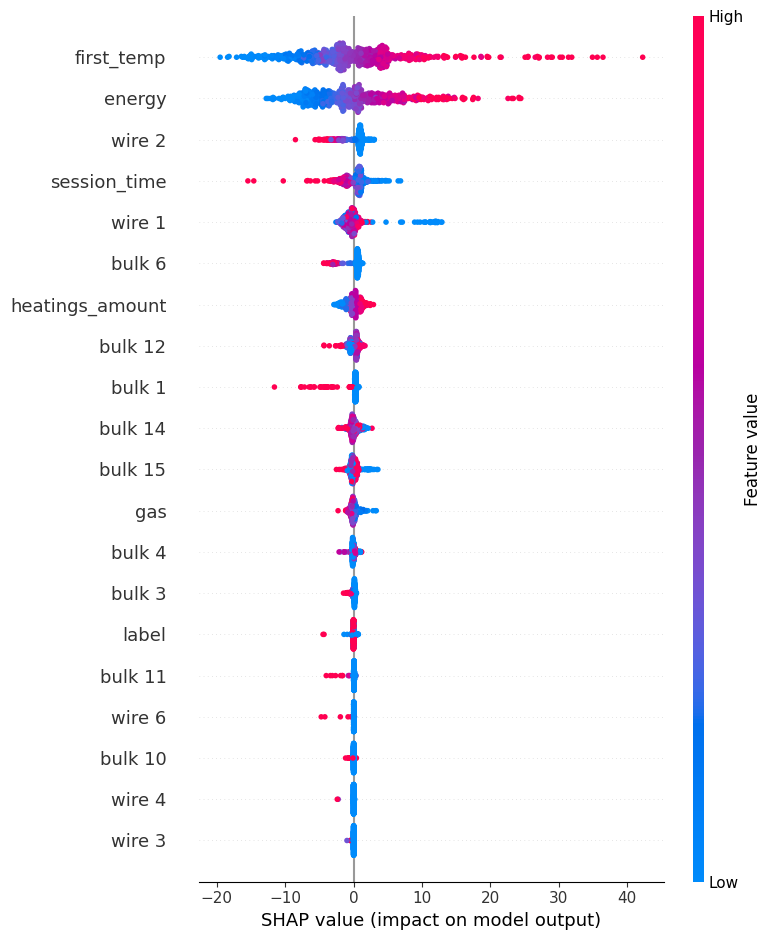

In [ ]:
# Features importance view.
shap_values = cat.get_feature_importance(Pool(features_test, label=target_test), type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.summary_plot(shap_values, features_test)

Как видно из SHAP-графика, наибольший вклад вносят признаки 'first_temp' и 'energy'.

In [ ]:
def plot_predictions_diff(predictions, actual):
    '''This function make visual difference between predictions and actual data.
    '''
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    plt.title('Предсказания и актуальные данные')

    ax[0].set_title('Диаграмма рассеяния предсказаний и реальных значений')
    ax[0].set_xlabel('Реальные значения')
    ax[0].set_ylabel('Предсказания')
    ax[0].grid(True)
    sns.scatterplot(x=actual.values, y=predictions, ax=ax[0], label='Предсказания')
    sns.scatterplot(x=actual.values, y=actual.values, ax=ax[0], label='Реальные данные', color='purple')

    ax[1].set_title('Зависимость остатков от реальных значений')
    ax[1].set_xlabel('Реальные значения')
    ax[1].set_ylabel('Остатки')
    ax[1].grid(True)
    sns.scatterplot(x=actual.values, y=predictions-actual.values, color='indigo', ax=ax[1])
    plt.grid(True)

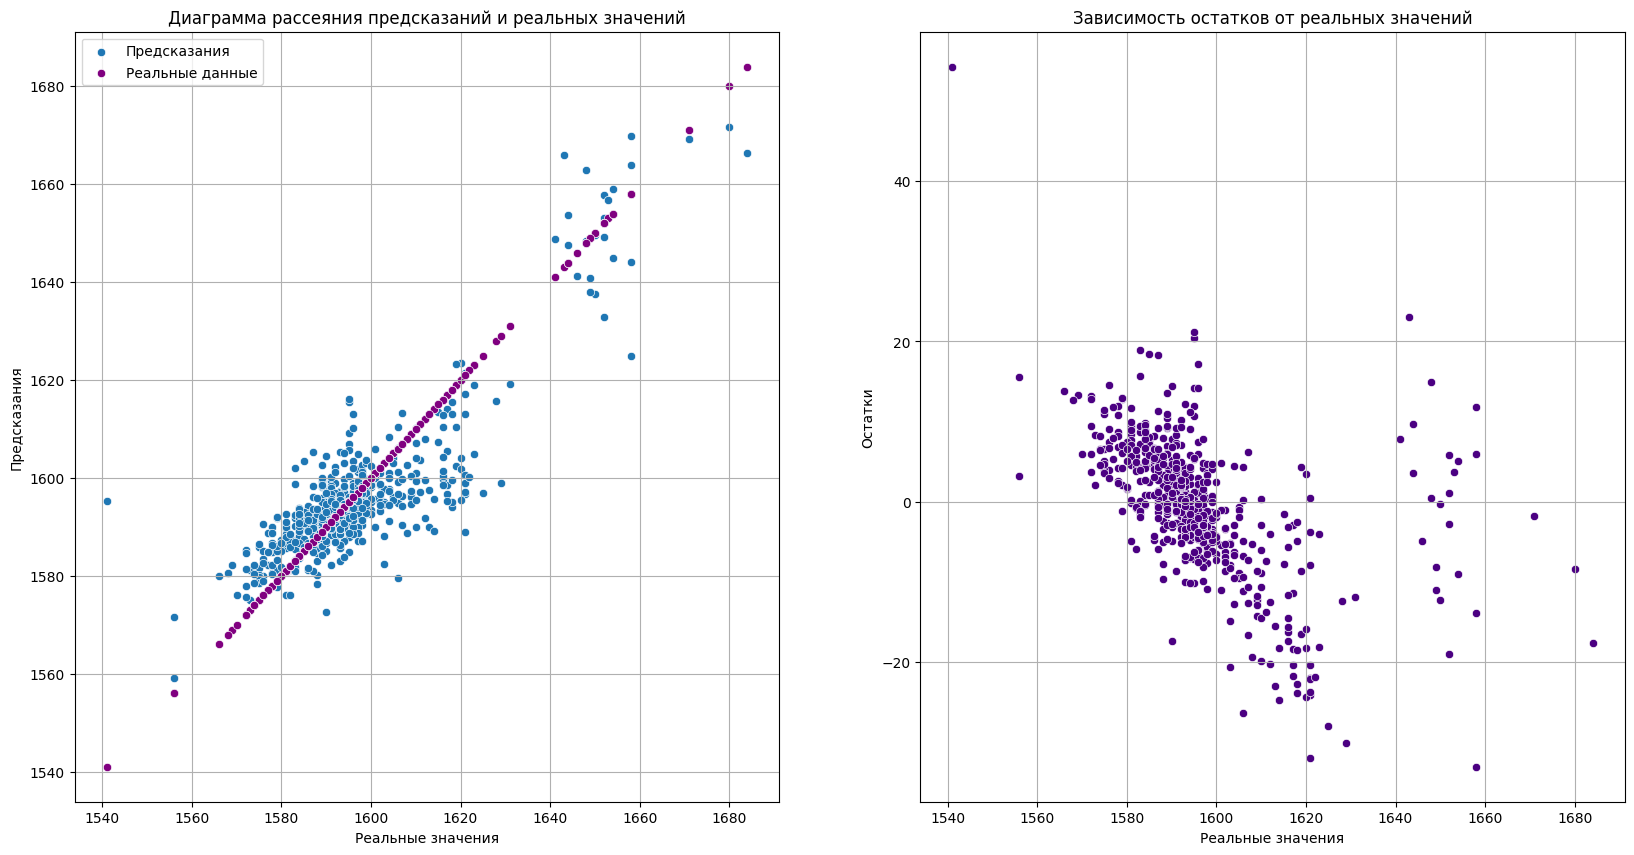

In [ ]:
cat_predictions = cat.predict(features_test)
plot_predictions_diff(cat_predictions, target_test)

## 5.6 Проверка на адекватность

In [ ]:
# Dummy model fit & predict.
for strategy in ['mean', 'median']:
    print(f'Strategy: {strategy}')
    dummy_regr = DummyRegressor(strategy=strategy)
    dummy_regr.fit(features_train, target_train)


    # Score on train.
    dummy_predictions = dummy_regr.predict(features_train)
    dummy_score_train = mean_absolute_error(target_train, dummy_predictions)
    print(f'MAE dummy на тренировочной выборке: {round(dummy_score_train, 2)}')

    # Score on test.
    dummy_predictions = dummy_regr.predict(features_test)
    dummy_score_test = mean_absolute_error(target_test, dummy_predictions)
    print(f'MAE dummy на тестовой выборке: {round(dummy_score_test, 2)}')
    print()

Strategy: mean
MAE dummy на тренировочной выборке: 10.07
MAE dummy на тестовой выборке: 10.51

Strategy: median
MAE dummy на тренировочной выборке: 9.78
MAE dummy на тестовой выборке: 10.22



Все обученные модели показали результат лучший, чем константные предсказания.

## 5.7 Сравнение моделей

За время обучения модели принимается время, затраченное CPU на обучение непосредственно той модели, которая показала наилучшее значение MAE (временные затраты на GridSearchCV не учитываются).

In [ ]:
models_stat = pd.DataFrame(
    {'model': ['lin_reg', 'tree', 'forest', 'lgbm', 'cat'],
    'mae' : [lin_reg_score, tree_score, forest_score, lgbm_score, cat_score],
    'time_s' : [28/1000, 18.4/1000, 3.61, 36.7, 8.54]})

In [ ]:
models_stat

,model,mae,time_s
0,lin_reg,7.860347,0.0280
1,tree,7.129301,0.0184
2,forest,6.318191,3.6100
3,lgbm,6.047505,36.7000
4,cat,5.985454,8.5400


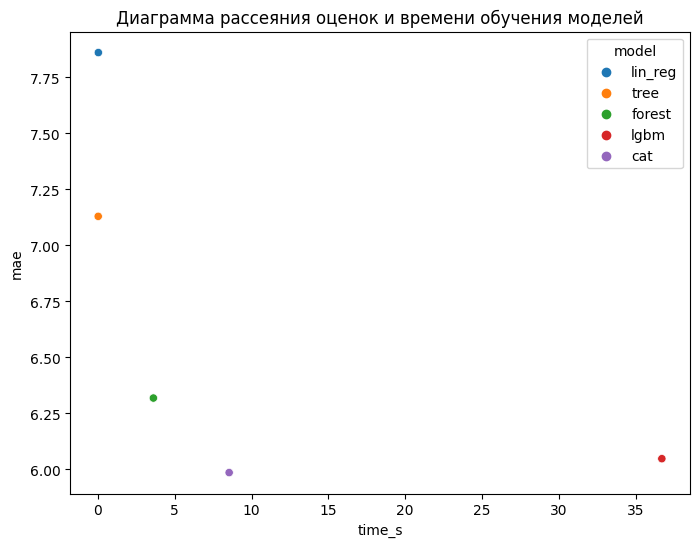

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title('Диаграмма рассеяния оценок и времени обучения моделей')
sns.scatterplot(data=models_stat, x='time_s', y='mae', hue='model', legend='full')
plt.show()

In [ ]:
fig = px.scatter(models_stat,
                 x='time_s',
                 y='mae',
                 color='model',
                 title='Диаграмма рассеяния оценок и времени обучения моделей',
                 width=700, height=500)
fig.show()

С точки зрения баланса качество-скорость наилучшими моделями являются случайный лес и Catboost. Однако поскольку время обучения даных моделей измеряется единицами секунд, то лучшей будет та модель, которая имеет наилучший показатель метрики качества, т.е. Catboost.

## 5.8 Вывод

Наибольшее влияние на целевой признак имеют признаки 'energy' и 'first_temp'. Наилучшие результаты имеет модель Catboost. Заказчику предлагается использовать именно её.

# 6. Отчёт

## 6.1 Сравнение решения с изначальным планом

По сравнению с изначальным планом изменение всего одно: данные разбивались не на train + valid + test,  а на train и test, поскольку данных сравнительно немного. Для проверки гиперпараметров использовалась кроссвалидация.

Также стоит упомянуть расширение пункта "Подготовка данных": при объединении данных в одну таблицу было произведено преобразование некоторых старых признаков в новые, но об этом подробнее в следующем пункте.

## 6.2 Описание затруднений и их решения

Первой и главной трудностью было понять, как именно связаны исходные данные и тех. процесс, каким образом их можно связать с целевой переменной. Для решения данной подзадачи была составлена блок-схема техпроцесса, а также найдена приблизительная схема используемой установки.

Второй трудностью являлась высокая степень корреляции между признаками **'Активная мощность'** и **'Реактивная мощность**', при этом оба признака являются важными, поскольку в обоих содержится информация о затраченной энергии. Поскольку целью заказчика является уменьшение энергопотребления, удаление информации касательно полезной работы (ушедшей на нагрев) или потерь энергии вследствие конструктивных особенностей установки/цепи было сочтено недопустимым. Для решения этой проблемы был произведён расчёт полной энергии, затраченный на обработку каждой партии. Таким образом удалось избавиться от высокой степени корреляции между признаками, а также сократить их количество (1 вместо 4).

## 6.3 Ключевые шаги решения

Ключевые шаги решения:

1. Обзор данных, выявление пропусков и аномалий
2. Выделение целевой переменной с сопутствующим удалением непригодных партий (в том числе аномальной)
3. Преобразование энергетических признаков в новый вид (описано в предыдущем пункте)
4. Объединение признаков в одной таблице с последующим разбиением на train + test
5. Обучение моделей, подбор гиперпараметров, выявление лучшей модели с точки зрения качества предсказаний.
6. Оценка влияния признаков на предсказания модели.
7. Выбор финальной модели.



## 6.4 Итоговая модель и её качество

In [ ]:
models_stat

,model,mae,time_s
0,lin_reg,7.860347,0.0280
1,tree,7.129301,0.0184
2,forest,6.318191,3.6100
3,lgbm,6.047505,36.7000
4,cat,5.985454,8.5400


In [ ]:
fig.show()

Наилучший результат показала модель Catboost  с гиперпараметрами по умолчанию.

## 6.5 Дополнительно

Также в качестве потенциального решения проблемы энергозатрат предлагается провести оптимизацию техпроцесса по уменьшению потребляемой реактивной мощности. Согласно имеющимся данным, среднее значение реактивной мощности составляет 0.50 ± 0.31, в то время как активной — 0.68 ± 0.41. Т.е. чуть меньше половины энергии идёт не на нагрев стали.